In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

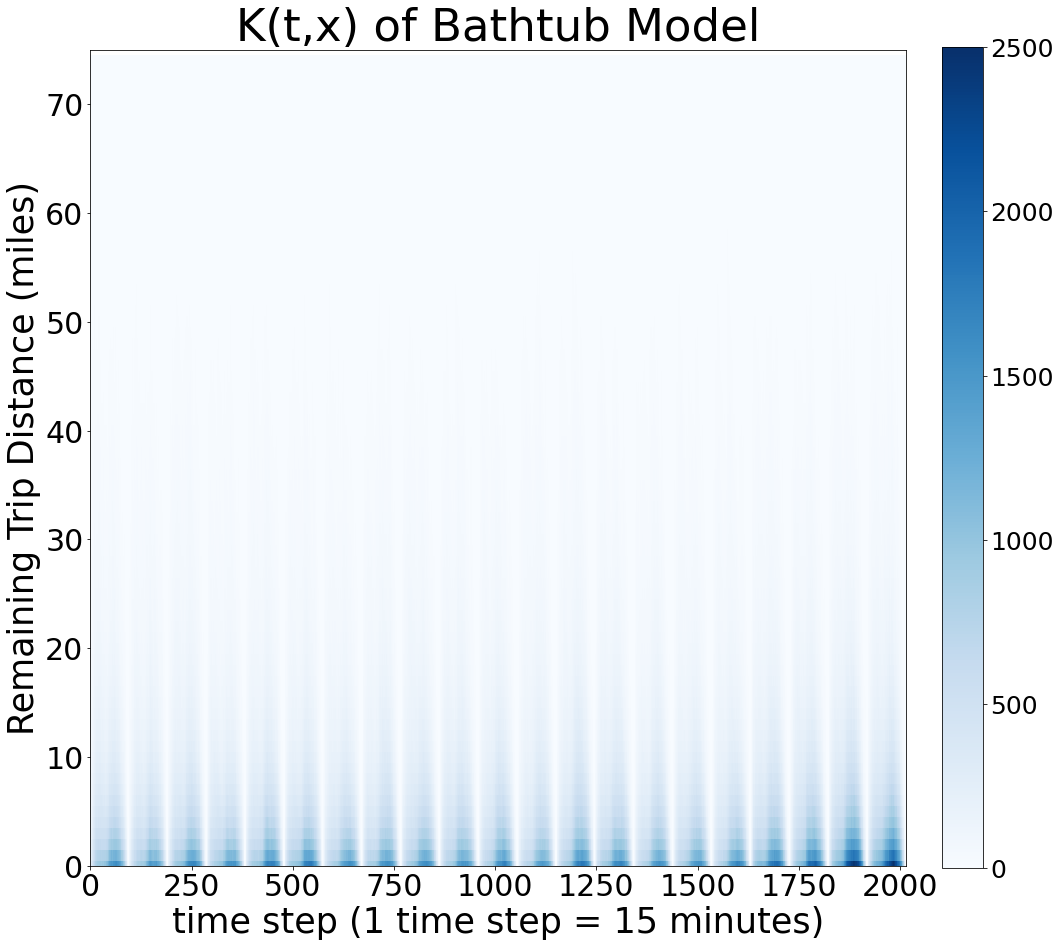

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0062742582279765669 0.011165387457663795 0.0013831289982893396 0.811151711654993
0.005412121362251195 0.0099594051966924863 0.00086483752780990378 0.7661386629467364
0.0051736781259992658 0.00991939967535448 0.000427956576644052 0.7640998550786434
0.0051723364643766478 0.0099218627519163174 0.0004228101768369789 0.7642031495713404
0.0051689653744397823 0.0099221626071181925 0.00041576814176137251 0.7641836083408087
0.005163936423860838 0.0099157902739267709 0.000412082573794905 0.76380802772969
0.0051557085396523768 0.0099016343760928941 0.00040978270321185867 0.7629362012827242
0.0051380656227452883 0.0098843280656500179 0.00039180317984055789 0.7619629651247799
0.0050645055980438666 0.0098090497888501157 0.0003199614072376169 0.7583715305953539
0.0049977818333656809 0.00970104626485929 0.00029451740187207197 0.7534989843530427
0.00493369692540564 0.0095476189568462315 0.00031977489396504738 0.7481721293944591
0.0048933935173235358 0.00938550282473504 0.00040128420991203211 0.742570

0.0032369851105220749 0.0055766547589788853 0.00089731546206526494 0.5779530373906281
0.0032366271228134028 0.0055792257433309178 0.00089402850229588766 0.578091839003483
0.0032363151527592142 0.0055754340761983035 0.0008971962293201248 0.577882182016435
0.0032360586915381735 0.0055767913517240355 0.00089532603135231181 0.5779389170783221
0.0032357586249335156 0.0055795195771843019 0.00089199767268272967 0.5780700831785146
0.0032353588105115084 0.0055784446125042072 0.00089227300851880986 0.5780071415035085
0.00323474732422855 0.005572855694417578 0.000896638954039522 0.5777343333949757
0.0032346043452300566 0.0055680824385139077 0.00090112625194620568 0.5774907170949993
0.003234268735935198 0.0055678712970753967 0.0009006661747949996 0.5774943514823934
0.0032340996123063292 0.0055680848436693723 0.00090011438094328585 0.577514164681552
0.003233811175574803 0.0055661966617598854 0.000901425689389721 0.5774151888560342
0.0032335926454791879 0.0055673942956868368 0.000899790995271539 0.5

0.0032119543797550758 0.0055202556410335942 0.0009036531184765578 0.574753301246802
0.0032118717704260839 0.0055183087940480447 0.00090543474680412331 0.5746584528545559
0.0032118038684106225 0.0055174246585493209 0.00090618307827192385 0.5746276036749635
0.0032117722014972242 0.0055177035269482573 0.00090584087604619131 0.5746514996959952
0.0032117587785715192 0.0055185745299113215 0.00090494302723171738 0.5746971256996392
0.0032117538708541491 0.00551959246426932 0.00090391527743897786 0.57475109183775
0.0032117504255569146 0.005519539800064319 0.00090396105104951032 0.5747496278613912
0.0032117333560980382 0.0055191354118736364 0.00090433130032243985 0.5747336629934149
0.0032117171291538805 0.0055185417703706163 0.00090489248793714481 0.5747062390717729
0.0032117047209764688 0.0055179927136280648 0.000905416728324873 0.5746781914532796
0.0032116989877666513 0.0055180973542713514 0.00090530062126195111 0.5746820908663137
0.0032116928601644756 0.005518685800043094 0.000904699920285856

0.0032050892419158154 0.0054864890912365138 0.000923689392595117 0.5731020915593895
0.0032047324275180466 0.0054884884190194855 0.00092097643601660758 0.5731827628072079
0.0032043848467518633 0.0054865975423075966 0.00092217215119612958 0.5730778398111777
0.0032040437555829679 0.0054876470705298268 0.00092044044063610911 0.5731101632230768
0.003203548930161166 0.0054918025621350508 0.0009152952981872815 0.5733146773398681
0.0032030208878919097 0.005503624814563751 0.00090241696122006834 0.573905549916327
0.0032023004349963462 0.0055020421883735385 0.00090255868161915362 0.5737584599235321
0.0032020311284553333 0.0054987508904094391 0.00090531136650122738 0.5735989569744873
0.0032011023360951573 0.0055071831566758343 0.00089502151551448046 0.5739677416513064
0.0032007360697398363 0.0055011383292360447 0.00090033381024362817 0.5736449908680121
0.0032000092604525334 0.0054819135867419681 0.00091810493416309854 0.5726773141972725
0.0031995087478472696 0.0054811094999450676 0.00091790799574

0.003179437079174955 0.0054482099586480853 0.00091066419970182479 0.5705560338117026
0.0031794237981553064 0.0054487722919152543 0.00091007530439535852 0.5705879396368231
0.003179416051591449 0.0054489296131986021 0.00090990248998429584 0.5705948876306404
0.0031793987740325177 0.00544949204116083 0.000909305506904205 0.5706191979329764
0.0031793879115957018 0.0054497346233492033 0.00090904119984219994 0.5706295546782965
0.0031793775098576363 0.0054500529064579611 0.00090870211325731179 0.5706465509809359
0.003179371702563159 0.005450981423568051 0.00090776198155826738 0.5706959556290431
0.0031793665757905874 0.0054510670624485138 0.00090766608913266144 0.5707020595501953
0.0031793609475096614 0.0054514933218008533 0.00090722857321846992 0.5707219795746143
0.0031793574114280937 0.0054507843805812776 0.00090793044227490988 0.5706879262916075
0.003179351601366725 0.0054509194262319432 0.00090778377650150644 0.5706893254679626
0.0031793485296631539 0.00545082508590779 0.0009078719734185180

0.0031775293825332747 0.0054493098578523424 0.000905748907214207 0.5705987048385951
0.0031775107491118391 0.0054483224038676652 0.00090669909435601287 0.5705535827653208
0.0031775018402534151 0.0054479341215409247 0.00090706955896590539 0.5705419864326047
0.0031774864723562468 0.0054478530871803349 0.00090711985753215885 0.5705359493842527
0.003177466891311204 0.0054474937049555265 0.000907440077666881 0.5705146209425712
0.003177445479923712 0.0054475244711689229 0.00090736648867850147 0.5705122588969028
0.0031774302135738827 0.0054476298566176785 0.00090723057053008723 0.5705128464526592
0.0031774255315416495 0.0054480739944720762 0.000906777068611223 0.5705199296975889
0.0031774152732091591 0.0054475679487360849 0.00090726259768223372 0.5705005310226122
0.003177413796236751 0.0054462872383833983 0.0009085403540901037 0.5704426135862889
0.0031774080718223411 0.0054463374781183261 0.00090847866552635614 0.5704462758094151
0.0031774044149743873 0.0054465458914429729 0.000908262938505801

0.0031767631993491288 0.0054474736331348852 0.00090605276556337243 0.5705059917081428
0.0031767215467401752 0.0054450632659846189 0.00090837982749573183 0.5703848785560469
0.0031766866753658966 0.0054435702874261315 0.00090980306330566208 0.570311049958308
0.0031766432591742218 0.0054455469899752631 0.00090773952837318057 0.5704120182790495
0.0031765734836683079 0.0054469986601433833 0.00090614830719323261 0.570490873947863
0.003176532179205075 0.0054469851463334147 0.00090607921207673525 0.5704877736399103
0.003176481677259028 0.0054500478218474117 0.00090291553267064415 0.5706473668809218
0.0031764422142648839 0.0054463022342830627 0.00090658219424670527 0.5704511468421571
0.0031764130139722525 0.0054450626991680426 0.00090776332877646234 0.570381761670174
0.0031763877606945925 0.00544468073765256 0.000908094783736625 0.570363871089742
0.003176369960095321 0.0054460779945988223 0.00090666192559181935 0.5704327424833567
0.0031763432427642114 0.0054453698218113709 0.0009073166637170516

0.0031733435034942063 0.0054312148584682038 0.00091547214852020879 0.5696032794672794
0.0031732352440323659 0.0054367742487675961 0.00090969623929713537 0.5698687513078924
0.0031731789205741829 0.0054416617168890069 0.00090469612425935853 0.5701192352103838
0.0031731239859377866 0.00544366325673736 0.000902584715138213 0.5702504333185896
0.0031730880081404841 0.0054411134228515784 0.00090506259342938993 0.5701159462406843
0.00317304330412636 0.0054400740516065763 0.00090601255664614334 0.5700487091189682
0.0031730179711907777 0.0054415328657276127 0.00090450307665394282 0.5701121041519944
0.0031729999825138352 0.00544082057440116 0.00090517939062650975 0.5700646642349614
0.0031729943160940946 0.0054390361023806382 0.00090695252980755117 0.5699812881280487
0.0031729835790924392 0.0054395123780896166 0.00090645478009526172 0.5700016010523694
0.0031729722556805258 0.0054403835227248938 0.000905560988636158 0.5700478813810758
0.0031729593007060429 0.0054403762014086973 0.000905542400003388

0.0031704438995030161 0.0054254207954775513 0.00091546700352848067 0.5692775933980979
0.0031701429952114635 0.0054192631017641914 0.00092102288865873565 0.5689126039132746
0.0031700564412142757 0.00542473615808264 0.00091537672434591091 0.569186211945223
0.003169764175922346 0.0054204415618600262 0.00091908678998466563 0.5689533726189632
0.0031696348612852985 0.0054213821060319443 0.000917887616538653 0.5690051532498874
0.0031695343097594597 0.0054220796084200641 0.00091698901109885512 0.569024406674979
0.0031694486877537984 0.0054287506216070657 0.000910146753900531 0.5693616276870919
0.00316937726308367 0.0054281910641218135 0.00091056346204552681 0.5693464919562886
0.0031693019603830637 0.005423743325068329 0.00091486059569779814 0.5691011546247913
0.0031692111664813412 0.0054302449004969174 0.00090817743246576494 0.5694397881046536
0.0031691929146029623 0.00542896917341718 0.00090941665578874375 0.5693597038348799
0.0031691299979848364 0.0054283860178986985 0.000909873978070974 0.5

0.0031675139320901814 0.0054288080526180985 0.00090621981156226421 0.5693232091287025
0.0031675091607058941 0.0054292566301362413 0.00090576169127554683 0.569346863933796
0.0031674949146264465 0.0054293991241078348 0.00090559070514505829 0.5693563857715533
0.0031674828599284723 0.0054284811080378336 0.00090648461181911093 0.5693040355508571
0.0031674791968009557 0.0054288548291912082 0.000906103564410703 0.5693220918161086
0.0031674725144203442 0.005428664454263433 0.00090628057457725533 0.5693161010525775
0.0031674700413183423 0.0054271806966082279 0.00090775938602845709 0.5692333609732115
0.003167458078499203 0.0054282729814051668 0.000906643175593239 0.5692940759311051
0.0031674486319222847 0.0054282798931583392 0.00090661737068623016 0.5693000042472957
0.0031674391114418833 0.0054299888811231989 0.00090488934176056741 0.5693970335264079
0.0031674211346083719 0.0054285337097937534 0.00090630855942299034 0.5693261023988005
0.0031674125218286195 0.0054275884273880049 0.000907236616269

0.0031669017033937384 0.0054252001272083765 0.00090860327957910055 0.569226959522298
0.0031668991540600312 0.0054243834120196307 0.0009094148961004318 0.569186964150478
0.0031668956771635152 0.0054247439634999414 0.00090904739082708929 0.5692052567578014
0.0031668920696954796 0.0054250228815821882 0.00090876125780877065 0.5692205530780967
0.0031668852219562962 0.0054249546378279442 0.00090881580608464792 0.5692150716123545
0.0031668819713111412 0.005425179359599591 0.00090858458302269158 0.569229636726713
0.0031668778253960764 0.0054261932554221454 0.00090756239537000767 0.5692768080285314
0.0031668749632388126 0.0054255467279539548 0.00090820319852367 0.5692468175807988
0.00316687324959167 0.0054258533014475167 0.00090789319773582327 0.5692633733246385
0.0031668707323768037 0.0054259972348066456 0.0009077442299469619 0.5692695325747977
0.003166866669626216 0.0054263992682651828 0.00090733407098724894 0.5692895373200537
0.0031668649368800971 0.0054259501778774538 0.00090777969588274048

0.0031666027677740554 0.0054254819711873322 0.000907723564360779 0.5692366023410113
0.003166602255409259 0.0054247420813784116 0.000908462429440106 0.5691968383242686
0.0031666004738900928 0.0054249820543223227 0.00090821889345786284 0.5692087924560577
0.0031665996606530674 0.0054251573053856316 0.000908042015920503 0.5692185758518207
0.003166598374219739 0.0054253549019513238 0.00090784184648815393 0.5692303002248977
0.0031665969551351557 0.0054253308349622685 0.00090786307530804308 0.5692310949987327
0.0031665961053362795 0.0054259372052230708 0.000907255005449488 0.5692631185116617
0.0031665950044448242 0.0054251433607097541 0.00090804664817989412 0.5692198096108961
0.003166593742848754 0.00542482972339263 0.00090835776230487845 0.5692062297993788
0.0031665927527266971 0.0054257531403636124 0.000907432365089782 0.5692531000038823
0.0031665915671797327 0.0054255312352016393 0.00090765189915782587 0.5692417320501361
0.00316659036220936 0.0054251232532164665 0.00090805747120225374 0.56

0.0031661701463715536 0.0054213821280466919 0.00091095816469641494 0.5689862743324606
0.0031661027710050567 0.0054214934164131482 0.00091071212559696538 0.5689815213149216
0.0031660802350736185 0.0054223502802236969 0.00090981018992354027 0.5690301838959456
0.0031659791075942952 0.0054192356576215923 0.00091272255756699836 0.5688684389487637
0.0031659518098046155 0.0054232372052319486 0.00090866641437728219 0.5690666229682098
0.0031658689326239473 0.0054253803714584608 0.00090635749378943393 0.5691703941652262
0.0031657985437555723 0.0054294152582159911 0.00090218182929515365 0.5693869048472023
0.003165716712391672 0.0054223691353981049 0.000909064289385239 0.5690428001225549
0.0031656882181104453 0.005422421048138064 0.00090895538808282654 0.5690411901039986
0.0031656477974644488 0.0054248489227588115 0.00090644667217008629 0.5691754369846983
0.0031655793374318134 0.0054302232546289183 0.00090093542023470875 0.5694633960511915
0.0031655191694484131 0.0054285484949515251 0.000902489843

0.0031635807756364236 0.0054286973713581835 0.00089846417991466354 0.5693764668308513
0.0031635793073863149 0.0054288343165781643 0.00089832429819446558 0.5693850638132195
0.0031635782774019632 0.0054292114387334651 0.00089794511607046111 0.5694042797175638
0.0031635767172196517 0.0054289338119914328 0.0008982196224478705 0.5693911059626888
0.003163573342100713 0.0054288513872603888 0.00089829529694103742 0.5693886007478142
0.0031635686514361475 0.0054288856444729356 0.00089825165839935931 0.5693933290378922
0.0031635642826132477 0.0054289198420560108 0.00089820872317048492 0.5693944650272762
0.0031635583243983037 0.005429029338799179 0.00089808730999742866 0.5693996088232333
0.0031635381507400819 0.0054292924618589812 0.00089778383962118289 0.5694108305664061
0.0031635121679933513 0.0054290535250025957 0.00089797081098410669 0.5693897079426437
0.0031634930789420416 0.0054291409570666315 0.00089784520081745184 0.5693948761763223
0.0031634714683117082 0.0054301997502954422 0.00089674318

0.0031627767529120356 0.0054290652902228157 0.0008964882156012559 0.569372763855919
0.0031627738859791978 0.00542886494550485 0.00089668282645354556 0.5693604133624666
0.0031627702348564195 0.0054289451164701782 0.00089659535324266085 0.5693635713917323
0.0031627674201553171 0.00542904462676253 0.00089649021354810444 0.5693660787468936
0.0031627622495835951 0.0054287037142448273 0.00089682078492236267 0.5693491603957294
0.00316275912957408 0.0054292700992077947 0.000896248159940365 0.5693795218131845
0.00316275671095348 0.0054294372330411381 0.00089607618886582228 0.5693862263899927
0.003162755102409313 0.0054296138238704335 0.00089589638094819224 0.5693953316257795
0.0031627520673789397 0.0054293330430143193 0.00089617109174356053 0.5693800768411577
0.0031627488094104982 0.0054297662462337269 0.00089573137258726918 0.5694009182189895
0.0031627476099989732 0.0054297687355538892 0.00089572648444405758 0.5694016490818375
0.0031627470120661689 0.005429533178172425 0.00089596084595991313 0

0.003161537605133507 0.0054359692818971433 0.00088710592836987057 0.5696545489415397
0.0031615285623183215 0.0054349055566742365 0.0008881515679624066 0.5696013279640381
0.0031615172125683579 0.0054357111537395074 0.0008873232713972085 0.5696414904905078
0.00316150886751589 0.0054370772723150874 0.0008859404627166921 0.5697138579944077
0.0031615022987113279 0.0054375710093789512 0.00088543358804370447 0.5697426608095023
0.0031614972367793432 0.0054374018982709972 0.00088559257528768938 0.569736172581342
0.0031614928037681611 0.0054381102939856331 0.0008848753135506888 0.569776911405758
0.0031614887009870623 0.005436908016621245 0.00088606938535287967 0.5697160424220736
0.0031614818437703802 0.0054364254906003337 0.00088653819694042651 0.5696913865941422
0.0031614690345503262 0.00543608759734006 0.0008868504717605923 0.5696724242881459
0.0031614621460566306 0.0054361016973979211 0.00088682259471534023 0.5696768119692468
0.0031614547556435366 0.0054365278121298235 0.00088638169915724945 

0.0031594260549329825 0.0054211332616352472 0.000897718848230718 0.568966648031722
0.0031594109618622379 0.0054191036960899554 0.00089971822763452059 0.5688668668690711
0.0031594002071099118 0.0054201568096049948 0.00089864360461482877 0.5689243728146399
0.003159390086338872 0.0054208593095683285 0.00089792086310941561 0.5689595613413216
0.003159375132873672 0.0054210788400610808 0.00089767142568626342 0.5689726150876194
0.0031593641639633147 0.0054213338600243273 0.00089739446790230255 0.5689769072838579
0.0031593539705884782 0.0054195871630505479 0.00089912077812640836 0.5688875602140048
0.0031593346541254497 0.0054176313370280183 0.00090103797122288113 0.5687876403989672
0.0031593110536472695 0.0054179579073235559 0.00090066419997098294 0.568804229734635
0.0031592652682163203 0.0054196156953080828 0.00089891484112455771 0.5688776923932951
0.003159251613345221 0.0054217059013081043 0.000896797325382338 0.568977710593154
0.0031592127639638685 0.005421892415630322 0.0008965331122974153

0.0031557347335810391 0.0054117044183812331 0.00089976504878084532 0.5684461258228743
0.0031556865241135763 0.0054124024552527844 0.0008989705929743682 0.5684797544520168
0.0031556139201141696 0.0054132420931826911 0.00089798574704564823 0.5685290871955148
0.0031555536971704518 0.0054161953094937427 0.00089491208484716064 0.5686622157882941
0.0031555081608989205 0.0054152399673563353 0.000895776354441506 0.5686208942946669
0.0031554412769848987 0.0054131279156242208 0.000897754638345577 0.5685328315658328
0.0031553800302300096 0.0054113341257677056 0.00089942593469231349 0.5684311178530028
0.0031553216866769675 0.0054109092255260781 0.00089973414782785663 0.5684110842912358
0.0031552641907650943 0.0054111402480093171 0.00089938813352087143 0.5684179351082553
0.003155227830297409 0.005414419813355803 0.00089603584723901494 0.5685518294526732
0.0031550863574459059 0.0054094437833675712 0.00090072893152424018 0.568315879524583
0.0031549882418872716 0.0054088152299302918 0.0009011612538442

0.0031484768039569642 0.0053772602485294349 0.00091969335938449327 0.5665984687062725
0.0031484123269501793 0.00537318220820806 0.00092364244569229851 0.5663884984872637
0.0031483471155198807 0.0053715902858502184 0.00092510394518954331 0.5663047948231207
0.003148279763863063 0.0053728651365726838 0.00092369439115344207 0.5663626749908551
0.003148201949016063 0.0053743866172192394 0.00092201728081288663 0.5664478193213848
0.0031481676697095772 0.0053730369728601261 0.000923298366559028 0.5663859732679928
0.0031481264983820954 0.00537195971942172 0.00092429327734247057 0.5663442307073779
0.0031480537066653456 0.0053694254143961456 0.00092668199893454549 0.5662153516482336
0.0031479448440815119 0.0053657175207776934 0.00093017216738533037 0.566031919794691
0.0031478759358271506 0.0053648019476580031 0.00093094992399629824 0.565975502493662
0.0031477454717285308 0.0053668887562082664 0.0009286021872487953 0.5660758004495425
0.003147624060324066 0.005367498802321141 0.00092774931832699059 

0.0031391611587659424 0.00537529005221128 0.00090303226532060491 0.5663696376619101
0.0031390828721264588 0.00537307429963112 0.00090509144462179816 0.5662597296658988
0.0031389892757117651 0.0053665094353645536 0.00091146911605897616 0.5659249240118908
0.0031389289741852685 0.0053657697535296183 0.00091208819484091871 0.5658986443901128
0.0031388957401007568 0.0053662542569897038 0.00091153722321181017 0.5659223105998377
0.0031388635921529261 0.005367487246309895 0.00091023993799595692 0.5659919057215873
0.0031388235620808738 0.0053675811549699949 0.00091006596919175251 0.5659938488663421
0.0031386845562160638 0.005367991582029271 0.00090937753040285668 0.5660186211289838
0.0031384515055404428 0.0053705824528871371 0.00090632055819374888 0.5661387009905257
0.0031381864833282297 0.005372831088799733 0.00090354187785672666 0.5662662675581466
0.003138092135277366 0.0053734518586778341 0.00090273241187689777 0.5662639584512953
0.0031377847841688538 0.0053759142281922393 0.0008996553401454

0.0031247286526686823 0.0053606801745587872 0.00088877713077857763 0.5657137455797533
0.0031246458694193366 0.0053602034991643227 0.00088908823967435069 0.5656800558977044
0.0031245049507559984 0.005358888481318113 0.00089012142019388382 0.565605757531264
0.0031243540754636243 0.0053533921955355324 0.0008953159553917163 0.5653174933822283
0.00312426941914837 0.0053549001614748327 0.000893638676821907 0.5653937606560627
0.0031242473549859288 0.0053600225933877988 0.00088847211658405845 0.56564263706977
0.0031241749677099482 0.005356964881763876 0.00089138505365602056 0.5654912318403392
0.0031240973658630908 0.0053574549714770223 0.0008907397602491594 0.5655300737670517
0.0031240415623687671 0.0053585770697835216 0.00088950605495401267 0.5655799003926706
0.0031239858329887458 0.0053593274654506707 0.00088864420052682134 0.5656135326733633
0.0031238691260916393 0.0053615264464871495 0.00088621180569612877 0.5657222692524497
0.0031237143118430935 0.0053624250315896342 0.0008850035920965524

0.0031214535525543791 0.00535967040939144 0.00088323669571731777 0.5656340608828935
0.003121397192245265 0.0053625280894923346 0.000880266294998195 0.5657772953484084
0.0031213174450633314 0.0053643972483177526 0.00087823764180891019 0.5658678540319362
0.0031212655563950397 0.0053643783885493146 0.00087815272424076436 0.5658471172292122
0.0031212406468351774 0.0053648525465259146 0.00087762874714444026 0.5658767759166348
0.0031212207719692473 0.0053641762151150716 0.00087826532882342274 0.5658523280724941
0.0031211990236206058 0.0053635402284425747 0.00087885781879863667 0.5658236307233514
0.0031211812490884333 0.0053640535196989875 0.00087830897847787875 0.565846216277503
0.0031211697554293628 0.0053633715853223232 0.00087896792553640254 0.5658096360097471
0.003121155901134048 0.0053641935701534494 0.00087811823211464662 0.5658499617620124
0.0031211385057175987 0.0053643164964231223 0.00087796051501207487 0.565855262938656
0.0031211175416561961 0.0053645736529178787 0.0008776614303945

0.0031179484272857733 0.0053467055481401715 0.000889191306431375 0.5648624709772617
0.0031177471609900916 0.00534565243789841 0.00088984188408177322 0.5647965853419662
0.0031175358617942504 0.0053444704685997428 0.00089060125498875806 0.5647291216485197
0.0031173815116440841 0.0053435109211323285 0.00089125210215584 0.5646798891782009
0.0031172220796856758 0.0053447948443341 0.00088964931503725177 0.5647508876520329
0.0031171278300928438 0.0053492191264304552 0.00088503653375523214 0.5649835695850987
0.003117073830440771 0.00534999547146262 0.00088415218941892133 0.565029898958934
0.0031168464759538904 0.0053458107183018367 0.00088788223360594372 0.5648101701865585
0.0031167299349108752 0.0053548384626932611 0.000878621407128489 0.5652942764401035
0.0031166772581270982 0.0053501971413322221 0.00088315737492197441 0.5650459676827561
0.0031164911245274616 0.0053543031222920839 0.000878679126762839 0.5652478851026056
0.0031163006986552758 0.00535674217139607 0.00087585922591448091 0.56537

0.0031092067922154475 0.0053412834999177865 0.000877130084513109 0.5644185355386269
0.0031091141717686805 0.0053398542439121073 0.00087837409962525392 0.5643283101011722
0.0031090386604093138 0.0053426049788290932 0.00087547234198953443 0.5644679969660111
0.0031089580328495692 0.0053379480526745005 0.00087996801302463775 0.5642213536679509
0.0031088363284891615 0.0053342600296233727 0.00088341262735495019 0.5640315162881226
0.0031087474591569068 0.0053340702604929785 0.000883424657820835 0.5640169349183004
0.0031086467187557958 0.0053339411216677809 0.00088335231584381042 0.5640213249695504
0.0031085623548671075 0.0053322130604068407 0.00088491164932737393 0.5639273717062258
0.0031084665531711979 0.0053361786946492769 0.000880754411693119 0.5641263128707205
0.003108375064792143 0.0053412856593669407 0.00087546447021734537 0.5643907491662057
0.0031083493599160712 0.0053391162688846607 0.00087758245094748184 0.5642761008186615
0.0031083097518181807 0.0053401344567854106 0.000876485046850

0.003099332500553686 0.0053260166987849711 0.00087264830232240079 0.5635188920603605
0.0030992990746381279 0.0053261823754924683 0.00087241577378378756 0.5635313024536333
0.0030992603226800979 0.0053234124569872861 0.00087510818837290927 0.5633992371252722
0.0030992323616058754 0.0053267055451696136 0.00087175917804213719 0.5635711327568006
0.003099190766199216 0.0053241259784333594 0.00087425555396507227 0.5634425770453901
0.0030991547352061553 0.0053238899027792412 0.00087441956763306987 0.5634307659394502
0.0030991249594446864 0.0053237749908744405 0.00087447492801493224 0.5634285872752487
0.0030990939048980127 0.0053246241996075449 0.00087356361018848031 0.5634668270493887
0.0030990434477087968 0.0053234050477629644 0.0008746818476546292 0.5633969685640455
0.0030990113860321373 0.0053264425587167272 0.00087158021334754737 0.5635566822962148
0.0030989514194836921 0.0053239109317574224 0.00087399190720996184 0.5634256571654188
0.0030988290467592718 0.0053222952556752938 0.00087536283

0.0030932449605685954 0.00532128018617725 0.00086520973495994092 0.5632834747148658
0.0030932271452184575 0.0053202705215711788 0.00086618376886573624 0.5632286333577413
0.0030931964521276672 0.0053198316257415407 0.00086656127851379413 0.5632040827046632
0.0030931505267684876 0.0053179015090755481 0.00086839954446142663 0.5631007434872636
0.0030931089691981968 0.0053186743999352444 0.00086754353846114885 0.563139079781246
0.003093022657890597 0.00531923386078819 0.00086681145499300334 0.5631570882094344
0.0030929303195399637 0.0053187644353426518 0.00086709620373727567 0.5631471523827147
0.0030928104521896656 0.0053244334479015639 0.00086118745647776761 0.5634499916007992
0.0030927591750751528 0.0053205267901553421 0.00086499155999496312 0.5632404172556458
0.0030926800069387417 0.00532275725596409 0.000862602757913393 0.5633538311216867
0.0030926478078667874 0.00532220296533603 0.000863092650397545 0.563324291936519
0.0030926089916829811 0.0053198015617429116 0.00086541642162305064 0.

0.00308971754344649 0.0053239978767847885 0.000855437210108192 0.5633322872023535
0.0030896768337187854 0.0053207422172002 0.00085861145023737018 0.5631353965684237
0.0030896034558516054 0.0053213066831693748 0.000857900228533836 0.5631741262424079
0.0030895643283310762 0.0053220700580747966 0.000857058598587356 0.5632188871562915
0.0030894899578644856 0.0053249268224232595 0.00085405309330571159 0.5633637623530989
0.00308941732707187 0.0053267785486027161 0.00085205610554102385 0.5634483378966764
0.0030893541223714523 0.0053265440207517362 0.00085216422399116837 0.5633954810246268
0.0030893293026594236 0.0053272631633452727 0.00085139544197357429 0.5634351439389744
0.0030892984846470034 0.0053290105700819906 0.00084958639921201614 0.5635323350824823
0.003089285191342122 0.0053313226804210809 0.000847247702263163 0.5636557930298417
0.0030892438199116852 0.0053322627025001431 0.000846224937323227 0.5637044062534459
0.0030892200360972391 0.0053290689753839743 0.00084937109681050354 0.563

0.0030848917049994813 0.0053203290300114859 0.00084945437998747652 0.5631065938032506
0.0030846848380078032 0.0053192249311906073 0.00085014474482499882 0.5630281019961905
0.0030845529533178057 0.0053204636755247638 0.00084864223111084773 0.563065547237264
0.003084436716918115 0.005316464083764981 0.00085240935007124927 0.5628591992442261
0.0030843896349745138 0.0053188658126909543 0.0008499134572580733 0.5629878870929003
0.003084360053170246 0.0053146144348064023 0.00085410567153408937 0.5627426531102828
0.0030842767748284 0.005312400656929667 0.0008561528927271331 0.5626688716920262
0.0030842280008199739 0.0053157446151916293 0.00085271138644831814 0.5628332293467075
0.0030841920806871539 0.0053154561488596447 0.00085292801251466278 0.5628136095870531
0.0030841065695286288 0.005313245428710668 0.00085496771034658959 0.562696863868862
0.0030841007822788235 0.0053128827155510061 0.0008553188490066408 0.5626759991583458
0.00308408822331724 0.0053152150547260612 0.00085296139190841865 0.

0.0030792213541893693 0.0053042316901752784 0.00085421101820345991 0.5622497142578974
0.0030789873740923236 0.0052977663649349293 0.000860208383249718 0.5619064373922327
0.0030785521059614445 0.00529557571088358 0.00086152850103930908 0.5617869317620775
0.003078351215848556 0.00529499383693283 0.00086170859476428219 0.5617643111174035
0.0030780838263758021 0.0052903921003545143 0.00086577555239708993 0.5614924305513349
0.0030779711568207622 0.0052869445443052988 0.00086899776933622584 0.5613222668791201
0.0030778861626654737 0.005292933706432028 0.00086283861889891974 0.5616324245869537
0.0030778140099305918 0.0052814973921837443 0.00087413062767743984 0.5610363043524218
0.0030776531748736174 0.00528990353597386 0.00086540281377337424 0.5614514920094726
0.0030776294302078 0.0052911608032928624 0.00086409805712273731 0.561542931593308
0.0030775522040447515 0.0052894281602805775 0.00086567624780892541 0.5614378000353866
0.0030775479654970737 0.0052872989862267211 0.0008677969447674264 0.

0.003075140025372606 0.0052807756661691916 0.00086950438457602023 0.5609854996861354
0.0030750505084740608 0.0052786486121267082 0.00087145240482141358 0.5608879177405306
0.0030750142989698949 0.0052828086146337128 0.00086721998330607732 0.5611110385771779
0.0030749353023179749 0.00528513794238851 0.00086473266224744016 0.5612313391075416
0.0030747991646643933 0.0052850239827240755 0.00086457434660471087 0.56122838042587
0.0030746967095499839 0.0052858168905775636 0.00086357652852240413 0.5612646928162147
0.0030744858818562374 0.0052797393519992131 0.00086923241171326163 0.5609459593743632
0.0030743015519174672 0.0052775955577757955 0.00087100754605913913 0.5608419533591776
0.0030740932670558245 0.0052852559449490183 0.00086293058916263039 0.5612424057640929
0.0030739727908684904 0.0052917910946928964 0.00085615448704408424 0.5615758355739182
0.0030737239515357395 0.00527669219908875 0.00087075570398272885 0.5607812752128928
0.0030735526686592575 0.00527295160920204 0.00087415372811647

0.0030641652448120636 0.0052475795607096762 0.00088075092891445124 0.5592449290950103
0.0030640548066954193 0.0052469485329549315 0.000881161080435907 0.5592000662093092
0.0030639808050485755 0.005244644352110076 0.00088331725798707528 0.5590745045307945
0.00306386243497883 0.005247726042435133 0.00087999882752252674 0.559239331707983
0.0030638061412977978 0.0052490722165457306 0.00087854006604986472 0.5593140291679276
0.0030637916176070078 0.0052481275183149795 0.00087945571689903657 0.5592747087630686
0.0030637740986689129 0.0052487338935067566 0.00087881430383106914 0.5593102467052746
0.0030637578783377414 0.0052477575351100062 0.00087975822156547627 0.5592632557874544
0.0030637257196548329 0.0052461056136758619 0.00088134582563380423 0.5591807056003794
0.003063680497713708 0.0052451798887679282 0.00088218110665948767 0.5591330881103947
0.0030636448196812711 0.0052442227142080926 0.00088306692515444985 0.5590786504402403
0.0030636153196306509 0.0052453158779483949 0.0008819147613129

0.0030609334132852871 0.0052469783553673027 0.000874888471203272 0.5591375292686999
0.0030608973590648698 0.0052485211101357086 0.00087327360799403135 0.5592196434078596
0.0030608551300492391 0.0052466171447099657 0.00087509311538851229 0.559119478921219
0.003060819646857285 0.0052484079234386 0.00087323137027596953 0.5592273344519759
0.003060790324175785 0.0052459130863550555 0.00087566756199651422 0.5591061859931469
0.0030607724544153333 0.0052453598131445922 0.00087618509568607433 0.5590764025718977
0.0030607617188459788 0.0052454496884060987 0.00087607374928585873 0.5590864587375329
0.0030607412453592178 0.0052466788960695461 0.00087480359464888987 0.5591481006387322
0.0030607143582382693 0.0052470765741010755 0.00087435214237546321 0.5591611575098437
0.0030606876046711663 0.0052486723467464877 0.00087270286259584528 0.5592451230190092
0.0030606439498056738 0.0052502894799305172 0.00087099841968083067 0.5593246169764676
0.0030606042816328357 0.0052484386042467076 0.0008727699590189

0.003057292485149314 0.0052324842222635547 0.00088210074803507369 0.5583769252307818
0.0030572796539834967 0.0052315441216121182 0.000883015186354875 0.5583284166053674
0.0030572497563995122 0.0052309079297777261 0.000883591583021298 0.5582910903747078
0.0030571953606942891 0.0052298716346177877 0.00088451908677079037 0.558244251883915
0.0030571460202854532 0.0052286236618017392 0.00088566837876916712 0.5581878549673613
0.0030571244899342018 0.005229316474569091 0.00088493250529931243 0.5582217939849271
0.0030570924696982555 0.0052304067999711205 0.00088377813942539017 0.5582894652740561
0.003057052218819811 0.0052300032325529079 0.000884101205086714 0.55826147369115
0.0030570366909473245 0.0052272104402961133 0.000886862941598536 0.5581326861638997
0.0030569608132550207 0.005228466848917512 0.00088545477759252947 0.5581920977987307
0.00305692731020495 0.0052300580757547758 0.00088379654465512391 0.5582733313146859
0.0030568850382476673 0.0052271891771689836 0.00088658089932635057 0.55

0.00305570958411381 0.0052175986967043248 0.00089382047152329548 0.5576494089338822
0.0030557017876217244 0.0052177996219651326 0.00089360395327831629 0.5576587113048427
0.0030556916761764657 0.0052182139210923736 0.000893169431260558 0.5576809533599199
0.0030556790034895588 0.0052198208120721422 0.0008915371949069753 0.5577657337503629
0.003055668714074959 0.0052201413863068348 0.0008911960418430836 0.5577920395380573
0.00305565963203396 0.00522127746240568 0.00089004180166224044 0.5578512863557298
0.0030556433655701031 0.0052205988485545278 0.00089068788258567873 0.5578115077716603
0.0030556240837485032 0.0052190837680029618 0.00089216439949404459 0.5577317388697945
0.0030555941418835266 0.0052188654440698231 0.00089232283969723 0.5577189806162142
0.0030555574698623821 0.005218659115956736 0.00089245582376802819 0.5577150446408843
0.0030555557401665289 0.0052186537527527206 0.00089245772758033695 0.5577181036714483
0.0030555519624637295 0.0052182533429564124 0.00089285058197104681 0.

0.0030541878112950792 0.0052136380876261733 0.00089473753496398527 0.5574246302591838
0.0030541863928315047 0.0052133536788225333 0.00089501910684047629 0.5574105280589545
0.003054184385155563 0.0052131452470423221 0.00089522352326880373 0.5573993985428852
0.0030541806808153439 0.0052128016696344126 0.00089555969199627526 0.5573795992106917
0.00305417549507955 0.0052127134234336752 0.00089563756672542442 0.5573717696931966
0.0030541668184583103 0.0052128060986488594 0.00089552753826776165 0.5573718552092649
0.0030541524861887894 0.0052132631798364679 0.00089504179254111125 0.5573906268801118
0.0030541286333512813 0.0052143156459513555 0.00089394162075120715 0.5574396705936165
0.0030541122843041383 0.0052145427920620253 0.000893681776546251 0.5574507066558698
0.0030540648670470336 0.00521611361804729 0.00089201611604677747 0.5575255055934697
0.0030539816116002005 0.0052185771738679186 0.00088938604933248247 0.5576350504717464
0.0030539555527669994 0.0052182311875276482 0.000889679918006

0.0030532423933837555 0.0052175401028539013 0.00088894468391360947 0.5575691910843285
0.003053236742493816 0.0052174218066724475 0.00088905167831518459 0.5575583757296122
0.0030532316493888574 0.0052175728243829753 0.00088889047439473935 0.5575624783202625
0.0030532296271898948 0.0052176832585371759 0.00088877599584261373 0.5575691814970661
0.0030532276882897203 0.0052174364406358366 0.00088901893594360408 0.5575567427250343
0.0030532259025054269 0.0052177145634499612 0.00088873724156089229 0.5575705869300408
0.0030532247638876287 0.0052176385624948677 0.00088881096528038955 0.5575641859468792
0.0030532243293333889 0.0052177205598396333 0.00088872809882714447 0.5575684945118666
0.0030532241598180696 0.0052178185897124195 0.00088862972992372015 0.5575721857672283
0.0030532238919823507 0.0052177819570087209 0.00088866582695598054 0.5575699469382055
0.0030532238100866574 0.00521773729910038 0.00088871032107293475 0.5575663810355658
0.00305322367082746 0.0052177990022774711 0.0008886483393

0.0030527470365500514 0.005217839381935911 0.0008876546911641914 0.5575707861383288
0.0030527444443978094 0.0052180906995400985 0.00088739818925552 0.5575838872521244
0.0030527408511363033 0.0052182304943100277 0.00088725120796257927 0.5575934726705154
0.0030527382996096662 0.005218234038944271 0.00088724256027506159 0.5575960629322013
0.0030527350218707266 0.00521811423162301 0.0008873558121184435 0.5575922842007808
0.0030527317990986357 0.00521785551547493 0.00088760808272234191 0.557581443145353
0.0030527260161743452 0.0052173752910684885 0.00088807674128020184 0.5575577898553703
0.0030527199592219408 0.005217647636752607 0.00088779228169127435 0.5575736961532383
0.003052712096839401 0.0052172256007570472 0.0008881985929217553 0.5575522353718495
0.0030526975108579996 0.0052171313295825946 0.00088826369213340476 0.557540500966048
0.0030526890960949995 0.005217511672898527 0.00088786651929147209 0.5575641259798599
0.0030526833870604809 0.0052182450472308354 0.00088712172689012626 0.55

0.0030520459022316711 0.0052137194133093619 0.00089037239115398047 0.5573550600624859
0.0030520442361424032 0.0052140218808775923 0.00089006659140721423 0.5573703656022911
0.0030520424669053929 0.005213668793609144 0.00089041614020164163 0.5573510057411589
0.0030520404883863849 0.0052139196157500352 0.000890161361022735 0.5573641124695388
0.0030520381390410152 0.00521404634366205 0.00089002993441998049 0.5573685641795332
0.0030520359116717609 0.005213977714874204 0.00089009410846931818 0.5573649520213285
0.0030520317686686888 0.0052142000268671374 0.00088986351047024015 0.55737468861507
0.00305202853329055 0.0052142678273844924 0.00088978923919660815 0.55737400460051
0.0030520260001334221 0.00521424940321799 0.00088980259704885456 0.557373464581416
0.0030520245470196661 0.0052145437635510274 0.00088950533048830476 0.5573882890886332
0.0030520233874248674 0.0052144103771316992 0.00088963639771803544 0.5573801146927709
0.0030520218901902386 0.005214582197860934 0.00088946158251954294 0.5

0.0030518269565477582 0.0052113528933426705 0.00089230101975284581 0.5572239846551014
0.0030518268290623488 0.00521129508239615 0.00089235857572854773 0.5572210789367084
0.0030518267316650125 0.0052111629054798761 0.00089249055785014879 0.5572140698678794
0.0030518266722858217 0.0052111670975461509 0.00089248624702549279 0.5572147302449137
0.0030518266128243578 0.005211140710181362 0.00089251251546735341 0.5572135085645207
0.0030518264875291578 0.00521111565965523 0.00089253731540308526 0.5572121991324422
0.0030518263549600632 0.0052110951234576415 0.00089255758646248468 0.5572111870166602
0.0030518261162081079 0.0052110893244803579 0.00089256290793585753 0.5572108602671981
0.0030518259471681388 0.0052112390857332073 0.00089241280860307011 0.5572184778988142
0.0030518257723219848 0.0052112151718994529 0.0008924363727445166 0.5572168469222732
0.003051825682012213 0.0052112037336550674 0.00089244763036935815 0.5572160301161548
0.0030518254259895715 0.0052111876614458884 0.000892463190533

0.0030514656515325247 0.0052048980742364914 0.00089803322882855768 0.5569120913338415
0.0030514652096252162 0.0052049744624394741 0.00089795595681095867 0.5569151995054926
0.0030514647644727128 0.0052050146857540447 0.00089791484319138052 0.5569179205802558
0.003051464376054793 0.005205064659463193 0.00089786409264639333 0.5569201314971473
0.0030514641602087632 0.00520511355619545 0.00089781476422207606 0.5569224601617502
0.0030514640449196329 0.0052051402640549867 0.00089778782578427932 0.5569239382626063
0.0030514638512765041 0.0052051266434494491 0.0008978010591035589 0.5569233648904832
0.0030514635814778727 0.0052050734213871267 0.00089785374156861825 0.5569207338939406
0.0030514632217710294 0.0052050214473823514 0.00089790499615970772 0.556918576440856
0.003051462853967569 0.00520490914187605 0.00089801656605908845 0.5569128259207117
0.0030514626686489574 0.0052050446652107188 0.00089788067208719578 0.5569200716309228
0.0030514625792348866 0.0052049670094365952 0.00089795814903317

0.0030510907464726422 0.0052016596171735666 0.000900521875771718 0.5567585255710179
0.00305108351961163 0.0052017783979060464 0.00090038864131721408 0.5567665743705681
0.0030510754975224125 0.0052014129807328871 0.00090073801431193791 0.5567465888705404
0.0030510684509643779 0.0052026623161574963 0.00089947458577125945 0.5568237340948189
0.0030510482232344177 0.0052034603124220379 0.00089863613404679707 0.5568557222369941
0.0030510286339238222 0.0052015911640751122 0.00090046610377253228 0.556762050816939
0.0030510136023580584 0.0052008856205201211 0.00090114158419599545 0.5567320082787774
0.0030509947236139626 0.0051987186968075975 0.00090327075042032729 0.5566170051369194
0.0030509841312182521 0.005199840422008154 0.00090212784042835025 0.5566726942681224
0.0030509585307263304 0.0051997950542223793 0.0009021220072302818 0.5566678566238887
0.0030509414460123405 0.0051991961771666352 0.00090268671485804611 0.5566460870847924
0.003050920127522365 0.0051990601945496057 0.0009027800604951

0.0030478733467737777 0.0051980840270028465 0.00089766266654470856 0.5565549664738408
0.0030478516247596575 0.0051983873442503891 0.0008973159052689261 0.5565678480083677
0.003047839002983149 0.005197341733763689 0.000898336272202609 0.5565141377231341
0.0030478255273929757 0.0051994214560592486 0.00089622959872670256 0.5566283236181938
0.003047819637788439 0.0051982451120996991 0.00089739416347717866 0.5565654001402335
0.0030478160653866055 0.0051978280224856078 0.000897804108287603 0.5565435439350153
0.0030478130298858862 0.0051987676612076511 0.00089685839856412089 0.5565959210923737
0.0030478081064019081 0.005197989343918818 0.00089762686888499846 0.5565567457053364
0.0030478045334714379 0.005198236223634225 0.000897372843308651 0.556568977608387
0.0030478002285967039 0.0051982454480569672 0.0008973550091364407 0.5565685328746489
0.0030477948463022379 0.0051983008164806 0.00089728887612387613 0.5565731564095063
0.0030477915080603084 0.0051981909727621626 0.00089739204335845463 0.55

0.0030471589869275175 0.0051925641013621125 0.00090175387249292267 0.5562837487232479
0.0030471398550832311 0.005192052895070038 0.000902226815096424 0.5562654394333468
0.0030471264661825134 0.0051902050484127242 0.00090404788395230258 0.556179924486334
0.0030471049286117744 0.0051921681066149456 0.00090204175060860339 0.5562816487612564
0.0030470890295419464 0.005192772509755493 0.00090140554932839959 0.5563112276863709
0.0030470860757829022 0.0051957893663229287 0.00089838278524287591 0.5564815959916195
0.003047071697010198 0.0051941666908172516 0.00089997670320314483 0.5563948710411729
0.0030470591093978996 0.0051927268335115549 0.00090139138528424394 0.5563116403390469
0.0030470469664917168 0.0051903807082773088 0.00090371322470612513 0.5561903230893059
0.0030470262783803661 0.0051904595380905666 0.0009035930186701653 0.5561971518259745
0.0030469904005246879 0.0051907609054144951 0.00090321989563488041 0.5562157215447909
0.0030469428673261922 0.0051925077190607622 0.000901378015591

0.0030457501443980337 0.0051888832674993291 0.00090261702129673823 0.5561029851952611
0.0030457344688977566 0.0051888494816510608 0.0009026194561444523 0.5560952847739027
0.003045716853253084 0.005189483456443226 0.000901950250062942 0.5561351736166221
0.0030456936627298418 0.0051910758323187719 0.00090031149314091189 0.5562170473412645
0.0030456853123941208 0.0051903291221913339 0.00090104150259690755 0.5561744349269195
0.0030456792148957665 0.0051879799401284175 0.00090337848966311576 0.5560558172491157
0.0030456607723601532 0.0051901615052670743 0.00090116003945323226 0.556177463089119
0.0030456491055303354 0.0051894779025193176 0.00090182030854135285 0.5561425134105609
0.0030456400378964812 0.0051903065364898122 0.00090097353930315 0.556184770732249
0.0030456308766409362 0.0051907612447855056 0.0009005005084963668 0.5562134281459198
0.0030456172350397481 0.0051895439538381721 0.00090169051624132391 0.5561527915056297
0.0030456152797339992 0.0051913463653369121 0.0008998841941310864

0.0030453094428077743 0.00518902892746468 0.00090158995815086893 0.5561186196268015
0.0030453079942168457 0.0051894022121938988 0.000901213776239793 0.5561382196267297
0.0030453065090820593 0.0051891764133461136 0.00090143660481800517 0.556126592183908
0.0030453059259538191 0.0051891674957060558 0.0009014443562015826 0.5561247206967515
0.0030453053258559554 0.0051887952457121385 0.00090181540599977225 0.5561055240466265
0.0030453047580845114 0.0051888805264595755 0.0009017289897094474 0.5561096059779166
0.0030453040273635242 0.0051890417990670765 0.00090156625565997227 0.5561176959670535
0.0030453031257815137 0.0051891656559094413 0.00090144059565358623 0.5561241956326586
0.0030453016426865644 0.0051893434225335289 0.00090125986283959953 0.5561334999909258
0.0030452993039647084 0.0051893438778211932 0.00090125473010822365 0.5561328932195768
0.0030452968927978065 0.0051894688928642574 0.00090112489273135564 0.5561402008344968
0.0030452952588941378 0.0051890729761219232 0.000901517541666

0.0030451714510855493 0.0051895565598905876 0.00090078634228051067 0.5561450275361378
0.0030451708518730324 0.0051896692679468453 0.00090067243579921978 0.556150007535869
0.00304517024236998 0.0051899254164840649 0.000900415068255895 0.5561628463629715
0.0030451697992060259 0.0051899563263771613 0.00090038327203489021 0.5561642590005695
0.0030451695410510424 0.0051899220543969978 0.00090041702770508728 0.5561626193993601
0.0030451693515953153 0.005189884570540336 0.00090045413265029458 0.5561611849546608
0.00304516922421799 0.0051898568028857714 0.00090048164555020863 0.5561595148239215
0.0030451690854373533 0.0051898815892686195 0.00090045658160608718 0.5561605560482069
0.003045169055614159 0.0051898688796971461 0.00090046923153117193 0.5561597192776382
0.003045168931742425 0.00518988188955132 0.00090045597393353 0.5561600373209142
0.003045168838438569 0.0051898614581709166 0.00090047621870622174 0.5561588814102585
0.0030451687361664746 0.0051898007144416409 0.00090053675789130837 0.5

0.003045061729864598 0.0051890998934130007 0.00090102356631619526 0.5561246992474362
0.00304506140941482 0.0051889737706054878 0.00090114904822415217 0.5561182014406914
0.003045061108449809 0.0051889188435765262 0.00090120337332309211 0.5561159278271217
0.0030450606496069312 0.0051889543836968772 0.00090116691551698537 0.5561182529914784
0.0030450605507717603 0.0051888725721753208 0.0009012485293682001 0.5561148778244708
0.0030450600710887113 0.0051890503150593247 0.00090106982711809776 0.556124555068443
0.0030450597901846483 0.0051890400366261247 0.00090107954374317163 0.5561237288571351
0.0030450595187815625 0.0051888837699619354 0.00090123526760118938 0.5561152571278399
0.0030450593617090019 0.0051888347504320366 0.00090128397298596741 0.5561127017708875
0.0030450593158283632 0.0051888885827717718 0.00090123004888495429 0.55611563046729
0.0030450592712340683 0.0051888307747363143 0.0009012877677318222 0.5561126776295582
0.003045059259649941 0.0051888519323751107 0.000901266586924771

0.0030450499594394005 0.0051886792057889083 0.00090142071308989236 0.5561050517098738
0.003045049907830881 0.0051886782006056115 0.00090142161505615023 0.55610482084314
0.003045049888344151 0.0051886854502925239 0.00090141432639577815 0.5561049641175393
0.0030450498506515247 0.0051887391396455195 0.00090136056165753 0.5561080090685453
0.0030450498335739982 0.0051887795516123393 0.00090132011553565759 0.5561102702164319
0.00304504981348784 0.005188759857183819 0.00090133976979186071 0.5561092852542019
0.0030450497973800667 0.0051887496317234985 0.00090134996303663532 0.5561088709916128
0.0030450497897255256 0.0051887415991600672 0.0009013579802909839 0.5561085195421042
0.0030450497831951986 0.0051887118332495192 0.00090138773314087767 0.5561069631339454
0.00304504977611322 0.0051887305024750519 0.00090136904975138764 0.556107798528953
0.0030450497721015331 0.0051887398137270965 0.00090135973047597 0.5561082361843641
0.0030450497671134645 0.0051887260463790528 0.00090137348784787659 0.55

0.0030446593234120236 0.0051888807876379157 0.00090043785918613188 0.5561160773837504
0.0030446585708938834 0.0051894260381810057 0.00089989110360676129 0.5561473948832989
0.0030446580642695563 0.0051891208479341753 0.00090019528060493741 0.556130687196703
0.0030446572586364006 0.00518892738344686 0.00090038713382594154 0.5561198046914669
0.0030446553496793587 0.0051885942625337017 0.00090071643682501591 0.5561019969103547
0.0030446519550922707 0.0051880758644696351 0.00090122804571490583 0.5560733728130529
0.0030446505104074844 0.0051884447026238267 0.00090085631819114185 0.556094715603703
0.0030446499041647986 0.0051890095677327094 0.00090029024059688789 0.5561275188532683
0.0030446477527131749 0.0051890002634010137 0.000900295242025336 0.5561294034307381
0.0030446463071311905 0.0051885197448301064 0.00090077286943227443 0.5561003393450596
0.0030446448411140092 0.0051882775355035641 0.00090101214672445417 0.5560886755807299
0.0030446436230243757 0.0051893336655844035 0.00089995358046

0.0030444314975733408 0.0051882981605339473 0.00090056483461273457 0.5560930300240987
0.0030444306591112056 0.005188382172696725 0.00090047914552568616 0.5560976533371339
0.0030444292332687476 0.0051884637030276109 0.00090039476350988455 0.5561017043813605
0.0030444271431456344 0.00518855854756819 0.00090029573872307865 0.5561074838897999
0.0030444237042255027 0.0051884366645401367 0.000900410743910869 0.5561020556852917
0.0030444195718247087 0.0051876808466378042 0.00090115829701161332 0.5560659174734788
0.0030444182382671423 0.005187651005024759 0.00090118547150952542 0.5560641027536186
0.0030444159776989396 0.0051879202435081671 0.00090091171188971212 0.556079169207568
0.0030444126606493493 0.0051869828439537694 0.00090184247734492881 0.5560286330623834
0.0030444094769597535 0.0051874501198169824 0.00090136883410252429 0.5560508622075441
0.0030444070110418327 0.0051877652179406668 0.00090104880414299861 0.5560663184108329
0.0030444056381940983 0.0051880502322268224 0.000900761044161

0.0030443815987771052 0.0051884292294675774 0.00090033396808663322 0.5560973316248536
0.003044381151137596 0.0051884258637469489 0.00090033643852824286 0.5560969604750478
0.00304438108692199 0.00518834317727605 0.00090041899656792947 0.5560934517257353
0.0030443807713169476 0.0051884462134393515 0.00090031532919454386 0.5560987027380996
0.0030443806613140766 0.0051884959551817831 0.00090026536744637056 0.5561009295471138
0.0030443804143323819 0.0051883409984265928 0.00090041983023817125 0.5560924948190474
0.0030443803439874685 0.0051883814989762186 0.00090037918899871867 0.5560954143370233
0.0030443802588836257 0.00518838044470079 0.00090038007306646119 0.5560949660877328
0.0030443802119308936 0.0051883590054490917 0.00090040141841269523 0.5560938560997256
0.0030443801870304989 0.005188349763363141 0.00090041061069785679 0.5560932374025835
0.0030443801669294093 0.0051884110806270116 0.000900349253231807 0.5560965636353637
0.0030443801532155372 0.00518838253615795 0.00090037777027312442

0.0030435597514192098 0.0051876007519037 0.00089951875093472009 0.556047103197865
0.0030435467375544405 0.0051873160076933546 0.0008997774674155269 0.5560305174473921
0.0030435291680929273 0.0051879859728594692 0.00089907236332638493 0.5560498805066099
0.0030435226524903889 0.00518868762283222 0.000898357682148558 0.5560877913378196
0.0030435189001324419 0.0051877797476632325 0.00089925805260165155 0.5560388933899183
0.0030435041447804752 0.005188038719804733 0.00089896956975621725 0.5560498562319547
0.00304349025725162 0.0051890658376066313 0.00089791467689660884 0.556105247189044
0.0030434749029159816 0.0051891194335920094 0.00089783037223995345 0.556107075840859
0.0030434594117137756 0.0051876518716708845 0.00089926695175666666 0.5560312642070336
0.0030434470032557146 0.0051891134381064586 0.00089778056840497059 0.5561115955698162
0.0030434360238838368 0.0051874658353823419 0.00089940621238533214 0.5560239914619935
0.0030434294710985237 0.0051873008591166057 0.00089955808308044189 0

0.0030425774713065596 0.0051887891134570928 0.00089636582915602649 0.5560883573393255
0.0030425688819562054 0.0051887874345489466 0.00089635032936346442 0.5560858404442687
0.0030425603125065169 0.00518862201076122 0.00089649861425181382 0.5560802168240203
0.0030425532043451826 0.0051894819743956658 0.00089562443429469962 0.5561251309604293
0.0030425483083458826 0.0051883902023650546 0.00089670641432671035 0.5560676475764639
0.00304254021887564 0.0051881977909084536 0.00089688264684282658 0.5560594892812165
0.0030425267430654879 0.0051880777256835386 0.000896975760447437 0.5560550229629776
0.0030425144624053242 0.0051857418391869714 0.0008992870856236769 0.5559333584975529
0.0030424969109138968 0.005185971727426188 0.00089902209440160554 0.5559425458931764
0.0030424794656099536 0.0051865246610981273 0.00089843427012177991 0.5559757267299588
0.0030424512115732483 0.0051875873463127029 0.00089731507683379408 0.5560362269183462
0.003042398713446505 0.0051872475729524354 0.00089754985394057

0.0030415662909626462 0.0051841358870645072 0.000898996694860785 0.5558152545418077
0.0030415620944380956 0.0051843460092256023 0.00089877817965058893 0.5558233511575311
0.0030415576331746163 0.005184246772673636 0.00089886849367559632 0.5558154709870122
0.0030415526612419456 0.0051839727483802287 0.00089913257410366258 0.5557947966690596
0.0030415461608814028 0.0051836030555432152 0.00089948926621959049 0.5557763745798929
0.0030415332861003083 0.0051834966396840879 0.00089956993251652853 0.5557720401436598
0.0030415223814982744 0.0051839292386635372 0.00089911552433301193 0.5557998672961102
0.0030415143225682516 0.0051849998508683073 0.00089802879426819553 0.5558566027632986
0.0030415108741533121 0.0051852775816818783 0.00089774416662474581 0.5558747421738349
0.0030415090579246776 0.0051854380964616266 0.000897580019387729 0.5558810242474931
0.0030415084415059287 0.0051852225969560052 0.00089779428605585244 0.5558688909451103
0.0030415069074816252 0.0051852003749750025 0.0008978134399

0.0030403242215664124 0.0051780817603569868 0.00090256668277583852 0.5554971082796242
0.0030403161888079549 0.005177588197822513 0.00090304417979339673 0.5554696979520823
0.0030403097287689342 0.0051784991772508577 0.00090212028028701047 0.5555173573622659
0.0030403031725508346 0.0051773321942452178 0.00090327415085645127 0.5554562781519764
0.0030403005849844417 0.0051785293145334647 0.00090207185543541841 0.5555197402797911
0.0030402960814268389 0.0051774926881594024 0.00090309947469427508 0.5554655790311372
0.0030402913354012464 0.0051774506543538854 0.00090313201644860763 0.555460706996972
0.0030402819208982974 0.005177154190888612 0.000903409650907983 0.5554407270280075
0.0030402708413871087 0.0051788748864232724 0.000901666796350945 0.5555304701004907
0.0030402541479370151 0.0051784423239105738 0.00090206597196345619 0.5554930642110013
0.0030402351174502683 0.0051789511665735208 0.00090151906832701585 0.5555246475536846
0.0030402230420040013 0.0051783588619773533 0.000902087222030

0.0030390400536648736 0.0051771550766505853 0.0009009250306791618 0.555459355210421
0.0030390306616011331 0.0051763724359066938 0.00090168888729557273 0.5554134940166903
0.0030390269794305881 0.0051773964382846238 0.0009006575205765527 0.5554768255747434
0.0030390214027141977 0.0051751944523459386 0.00090284835308245719 0.555358912555097
0.0030390198757596705 0.0051759528510386668 0.00090208690048067426 0.5553950562113321
0.0030390167420512836 0.0051757435912183894 0.00090228989288417753 0.5553850111324198
0.0030390128821581285 0.0051752737499603007 0.00090275201435595592 0.5553626764219383
0.0030390087933090839 0.0051750393475797681 0.00090297823903839967 0.5553501525485464
0.0030390030579496535 0.00517337169629443 0.00090463441960487751 0.555265080107105
0.0030389965357778565 0.0051750691931806148 0.00090292387837509838 0.5553511882466909
0.0030389912866839357 0.0051737136798484353 0.00090426889351943591 0.555272851114348
0.0030389804729192465 0.0051745553206955916 0.0009034056251429

0.0030377587474193475 0.0051687897280212093 0.0009067277668174861 0.5549606583374479
0.0030377557603408025 0.0051692525703033888 0.0009062589503782164 0.5549874300495381
0.0030377510246700906 0.0051690937513033421 0.00090640829803683885 0.554981996646799
0.0030377444636957361 0.00516945935447729 0.00090602957291418217 0.5550040973014951
0.0030377409480674532 0.0051695196621578347 0.00090596223397707216 0.5550081596522632
0.003037738614758756 0.0051692932648292125 0.00090618396468829926 0.554997599045291
0.0030377369193213717 0.0051705423243156075 0.00090493151432713588 0.555065242108596
0.0030377345040554105 0.0051694716711830156 0.0009059973369278055 0.5550088001402114
0.0030377330947006548 0.0051697276340375116 0.000905738555363798 0.5550216772843026
0.0030377312955193027 0.0051700962616512526 0.00090536632938735312 0.555041576970426
0.0030377277371325352 0.0051705562413988338 0.00090489923286623608 0.5550662562874763
0.0030377241152786259 0.0051703429194070059 0.00090510531115024632

0.0030368455587996982 0.0051689834757634376 0.0009047076418359592 0.554999767864645
0.0030368407540948697 0.0051680617392291968 0.00090561976896054225 0.5549557370218676
0.0030368380305964278 0.0051684269003528932 0.00090524916083996234 0.5549770182189482
0.0030368358688636922 0.0051665994670441941 0.00090707227068319014 0.5548792980273803
0.0030368320128493693 0.0051674570861929663 0.00090620693950577255 0.5549246043534407
0.0030368285316729983 0.0051698031721692135 0.00090385389117678269 0.5550485148996421
0.0030368237876172307 0.0051682886531785556 0.00090535892205590568 0.5549661143034081
0.0030368212805804186 0.0051683764903599572 0.00090526607080088008 0.5549713930918566
0.0030368204619671858 0.0051687176956834915 0.00090492322825088062 0.5549932536847278
0.0030368188962667463 0.0051684377905307785 0.00090520000200271374 0.5549755058928639
0.0030368175075559368 0.0051684175663483187 0.00090521744876355446 0.5549760587283256
0.0030368169502463008 0.0051685191602381473 0.0009051147

0.0030357626841892743 0.0051650359659184356 0.00090648940246011278 0.5548091460599857
0.0030357607690014929 0.0051658221550248649 0.00090569938297812061 0.554850289914069
0.0030357554289077 0.0051654432639871815 0.00090606759382821835 0.5548314728526711
0.0030357481534656451 0.0051655460334186628 0.00090595027351262735 0.5548385296983936
0.0030357367398906928 0.0051659445830898607 0.00090552889669152448 0.5548620606431414
0.0030357223584649806 0.0051672426558602982 0.00090420206106966332 0.5549288867688466
0.003035705187711556 0.0051677359694865766 0.00090367440593653507 0.5549501169082205
0.0030356881293094008 0.0051673901198560452 0.00090398613876275656 0.5549223694422415
0.0030356784395780671 0.005168456988516288 0.00090289989063984635 0.5549834544088901
0.0030356658958464507 0.0051643628885015532 0.00090696890319134861 0.5547713811395416
0.00303565934632504 0.005165132742466127 0.00090618595018395246 0.5548107782845814
0.003035654669177336 0.0051652769538919792 0.000906032384462692

0.0030353821955897997 0.0051628439456115035 0.00090792044556809576 0.5546666922122637
0.0030353375109841967 0.0051656028110451929 0.00090507221092320082 0.5548117554250266
0.0030352803677009075 0.0051673009744334589 0.00090325976096835648 0.554897205548668
0.0030352131664190571 0.0051662534718744614 0.00090417286096365244 0.5548259850560445
0.0030351854525706534 0.0051692751602431036 0.0009010957448982031 0.5549904263741419
0.003035115517819432 0.0051652698285662036 0.00090496120707266026 0.5547909224241121
0.00303508894517257 0.0051645047559853831 0.00090567313435975657 0.5547441946138566
0.0030350494090123884 0.00516475843943036 0.0009053403785944167 0.5547512565467791
0.0030350119389860961 0.0051634279710876963 0.000906595906884496 0.5546754452105519
0.0030349828302358925 0.005162668219714229 0.00090729744075755561 0.5546259150255056
0.0030349607285865081 0.0051635636493988927 0.00090635780777412341 0.5546718992451818
0.0030349477443337215 0.0051607516690683345 0.0009091438195991081

0.0030343565600788316 0.0051620023098989968 0.00090671081025866672 0.5546260036973272
0.0030343564388939288 0.0051620438080334213 0.000906669069754436 0.5546282860444707
0.0030343563436882755 0.005161936923561164 0.00090677576381538742 0.5546226698229342
0.003034356223952323 0.0051619479634272356 0.00090676448447741078 0.5546232685553327
0.0030343561611332012 0.0051619693732953345 0.00090674294897106762 0.5546242622879148
0.0030343561337538914 0.0051619190625630321 0.00090679320494475065 0.5546214337695456
0.0030343560916179985 0.0051618743223103489 0.00090683786092564844 0.5546190818328967
0.0030343560501168093 0.0051618227911916443 0.00090688930904197433 0.5546164384350956
0.0030343560092880176 0.0051618842486932937 0.00090682776988274167 0.5546199173875415
0.0030343559650386773 0.00516186547094479 0.00090684645913256443 0.5546190900958096
0.0030343559314574557 0.0051618988157080712 0.00090681304720684034 0.5546208878606328
0.0030343558897944311 0.0051619707869500027 0.00090674099263

0.003034328934911284 0.005162783685543364 0.00090587418427920407 0.5546788418215538
0.0030343252114111334 0.0051614534355530258 0.00090719698726924084 0.5546126293370043
0.0030343180712405571 0.0051612077008451832 0.00090742844163593068 0.554598063961129
0.0030343122718795067 0.0051624132723176227 0.00090621127144139028 0.5546607308465676
0.0030343040945982557 0.0051612436264615444 0.000907364562734967 0.5545965724134523
0.0030342868633674645 0.0051610410342028939 0.00090753269253203536 0.5545903896407768
0.0030342759309765991 0.00516290038664073 0.00090565147531246836 0.5546887421727136
0.0030342691078412707 0.0051637665853898375 0.00090477163029270406 0.5547323747039136
0.0030342630505977072 0.0051655218217358878 0.00090300427945952616 0.5548256490569896
0.0030342435455429839 0.0051624854106980958 0.00090600168038787172 0.5546686382257379
0.003034234455248766 0.0051642124840864841 0.00090425642641104762 0.5547637239502118
0.0030342258901528618 0.0051650959580839062 0.0009033558222218

0.0030340484441397251 0.0051647630814798682 0.0009033338067995822 0.554802963865477
0.0030340483438589787 0.0051647125352214914 0.00090338415249646578 0.5548003207055805
0.003034048179318342 0.0051646535003381381 0.00090344285829854559 0.5547972720475405
0.003034047932184251 0.0051646278458868811 0.00090346801848162112 0.5547956533220665
0.0030340476345841224 0.0051646840891487232 0.00090341118001952144 0.5547991899590913
0.0030340472262811004 0.0051646897241183964 0.00090340472844380464 0.5547988938514009
0.0030340467709270027 0.00516517571735608 0.00090291782449792527 0.5548234474996828
0.0030340463593360213 0.005164854177246791 0.00090323854142525153 0.5548068488421842
0.0030340461077931948 0.005164829022763104 0.00090326319282328573 0.5548054617774036
0.0030340457276829139 0.0051646561540123507 0.00090343530135347674 0.5547964933949792
0.0030340454111989815 0.0051647361796245735 0.00090335464277338973 0.554800630166685
0.0030340447035993932 0.0051648714855323354 0.00090321792166645

0.0030339520043490267 0.00516379443139142 0.00090410957730663332 0.5547307749557117
0.0030339503736685164 0.0051639406417647261 0.00090396010557230631 0.5547370238067777
0.0030339491236397085 0.005163793005010151 0.00090410524226926584 0.5547290042712276
0.0030339483697522833 0.0051642392923672035 0.00090365744713736271 0.5547522687271103
0.003033946358504912 0.005164285175720768 0.000903607541289056 0.5547534463849425
0.0030339443596591794 0.0051644533386745054 0.0009034353806438532 0.5547630013438487
0.0030339407503192691 0.005163218572536551 0.00090466292810198717 0.5546997031506736
0.003033939768866937 0.0051638180721497277 0.00090406146558414606 0.5547312552025704
0.0030339389510443847 0.0051639287698675958 0.00090394913222117371 0.5547370790676212
0.0030339383679378342 0.0051636631155848132 0.0009042136202908551 0.5547229330072017
0.0030339378593310187 0.0051634008747030473 0.00090447484395899 0.5547092896438315
0.0030339373771749714 0.005163709301726398 0.00090416545262354516 0.

0.0030338295377109643 0.0051642513738731468 0.00090340770154878223 0.5547510583303236
0.0030338286487881375 0.0051645429990356626 0.000903114298540612 0.5547661083089446
0.0030338266501086916 0.0051639977448224147 0.00090365555539496814 0.5547360524508844
0.0030338256134699549 0.0051648736610078825 0.000902777565932027 0.5547832909464182
0.0030338245967508684 0.005164060574564212 0.0009035886189375247 0.5547442689867887
0.0030338220046909623 0.0051642041586610638 0.00090343985072086075 0.5547482311713687
0.0030338208448269849 0.005164728433514335 0.00090291325613963444 0.554774561538207
0.0030338198023618888 0.0051639806052451408 0.00090365899947863722 0.5547353870313485
0.0030338182747289728 0.0051642377881172949 0.00090339876134065092 0.5547491804458425
0.0030338172493531265 0.0051640062285286349 0.00090362827017761809 0.5547377178291327
0.0030338164457500566 0.0051642587423683739 0.00090337414913173883 0.5547515331145692
0.0030338157348047891 0.005163670911356417 0.00090396055825316

0.0030336482037892874 0.00516522075128512 0.0009020756562934546 0.5548024538998866
0.0030336430848328772 0.0051628691912778248 0.00090441697838792938 0.5546757773013872
0.0030336387675682598 0.0051629600825738422 0.00090431745256267741 0.5546792053815531
0.0030336338896019433 0.0051645402106507447 0.0009027275685531415 0.5547633460488828
0.0030336284569965127 0.0051642541191907372 0.000903002794802288 0.5547484255104047
0.0030336220933949521 0.0051646190570725078 0.00090262512971739611 0.554764418684237
0.0030336183135378863 0.0051627863201584873 0.00090445030691728521 0.5546686091755886
0.0030336150968658746 0.0051635629709212089 0.00090366722281054056 0.5547147602826245
0.0030336121272378953 0.00516386119095606 0.00090336306351973138 0.5547323271631024
0.0030336079615876691 0.0051633176666353751 0.00090389825653996309 0.5547029758851065
0.0030336035633842773 0.0051626591492185655 0.0009045479775499891 0.5546687407580584
0.0030336013242430833 0.0051634957262730171 0.000903706922213149

0.0030290360063307074 0.0051537311175733755 0.00090434089508803917 0.5542672406862175
0.0030289905983165795 0.0051528863512082333 0.00090509484542492544 0.5542341680250318
0.0030289701329916205 0.0051526908720354436 0.00090524939394779713 0.5542240129991309
0.0030289541035620829 0.0051529275802802308 0.00090498062684393472 0.5542341358920954
0.003028941882392134 0.0051533334979582332 0.000904550266826035 0.5542466476494153
0.0030289257799063444 0.0051532509625155454 0.00090460059729714336 0.5542420369852449
0.0030289072075267904 0.0051535324806999284 0.00090428193435365244 0.554262076888629
0.0030288825897739268 0.0051537326273734156 0.00090403255217443826 0.5542733730561675
0.0030288633831534332 0.0051535922211129459 0.00090413454519392084 0.5542635279557585
0.0030288364965830143 0.0051549891080492159 0.0009026838851168129 0.5543312075665375
0.0030288105351565604 0.00515479467251968 0.00090282639779344144 0.5543247654993618
0.0030287837157819903 0.0051542599691024567 0.000903307462461

0.0030257559365944276 0.0051461831372835269 0.00090532873590532827 0.5538783755927565
0.0030257393047835191 0.0051456730181379312 0.00090580559142910738 0.553847258817873
0.0030257330383754622 0.0051448234183326105 0.00090664265841831394 0.5538043340089801
0.0030257239039478785 0.0051450551542663158 0.00090639265362944138 0.5538269402139855
0.0030257154721984479 0.0051451920102501374 0.0009062389341467585 0.5538330611685235
0.0030257076267234386 0.005145536180610661 0.00090587907283621661 0.5538502734723434
0.00302569744272528 0.0051449048411837759 0.00090649004426678385 0.5538147825108639
0.0030256903264524525 0.0051449460198261365 0.00090643463307876814 0.5538197067921773
0.0030256823961034751 0.0051435345564865044 0.00090783023572044608 0.5537463827398982
0.0030256745195014435 0.0051440258033962462 0.000907323235606641 0.5537759204774565
0.0030256639748739967 0.0051440078585445236 0.00090732009120346978 0.5537765621948891
0.0030256515426732252 0.005144254787456024 0.0009070482978904

0.0030248905168662127 0.005146687285243385 0.00090309374848904038 0.5539112228983837
0.00302487522292847 0.00514663629407223 0.00090311415178471034 0.5539064817542284
0.0030248681121717 0.0051464890841384269 0.00090324714020497288 0.553895521788543
0.0030248564899615165 0.0051452612367229346 0.00090445174320009827 0.5538364673687869
0.0030248368154732475 0.0051455529366494892 0.00090412069429700564 0.5538562884750176
0.0030248272771809491 0.005146901282580758 0.00090275327178113976 0.5539306459429226
0.0030248099407868992 0.0051467596096397786 0.00090286027193401959 0.5539168945232954
0.0030247939767098931 0.0051478252355370551 0.00090176271788273141 0.5539623740855132
0.0030247733579837829 0.0051459622146319628 0.00090358450133560338 0.5538696767213169
0.0030247521688429755 0.0051468520920161165 0.00090265224566983483 0.553922117422884
0.0030247421215171951 0.0051462427804778521 0.000903241462556538 0.553887890867837
0.0030247304713883652 0.00514630048024934 0.00090316046252739092 0.5

0.0030242783194503729 0.0051436863705400715 0.0009048702683606745 0.5537264540606389
0.0030242719147374848 0.0051435605298327828 0.00090498329964218676 0.5537196108322943
0.0030242672612198138 0.0051435531811805 0.00090498134125912807 0.5537199621576759
0.0030242541685518306 0.0051442883211687317 0.00090422001593492977 0.5537607808741277
0.0030242503487291112 0.0051438776552395881 0.00090462304221863388 0.5537330789834207
0.0030242436100666823 0.00514383530670258 0.00090465191343078448 0.5537302081401921
0.0030242394119810844 0.0051437697771347 0.00090470904682746916 0.5537277488451566
0.0030242341572016022 0.0051443923666765132 0.00090407594772669146 0.553761130103953
0.0030242291372380792 0.0051440121716750655 0.0009044461028010931 0.553736994819635
0.0030242198104296243 0.005143599258728376 0.000904840362130873 0.5537166399989596
0.0030242136690068738 0.005143504683961098 0.00090492265405264967 0.5537105492598006
0.003024207209657198 0.0051430684098151529 0.0009053460094992431 0.553

0.0030239719190655419 0.0051422923979313759 0.00090565144019970757 0.5536364929374693
0.003023971678890161 0.0051422433033882333 0.00090570005439208877 0.5536333741015056
0.0030239714447621519 0.0051422284693118658 0.00090571442021243772 0.5536322800744291
0.003023971081731228 0.005142318856034828 0.00090562330742762832 0.5536368326211429
0.0030239705886230118 0.0051423864710973067 0.00090555470614871669 0.5536404886348364
0.0030239699440378479 0.005142564530195376 0.00090537535788031971 0.5536507496165501
0.0030239692735755065 0.0051424587783276 0.00090547976882341254 0.5536447032992687
0.0030239685711618306 0.0051425366884663053 0.00090540045385735588 0.5536493706959982
0.0030239681445227659 0.0051423252134416416 0.00090561107560389008 0.5536375350783248
0.0030239679197306447 0.005142310556671234 0.00090562528279005522 0.553635833321784
0.0030239677994557948 0.0051421564442720577 0.00090577915463953176 0.5536278273106878
0.0030239676727313114 0.005142090244099934 0.000905845101362688

0.0030223828748651791 0.0051367172833999648 0.00090804846633039374 0.5533533129971006
0.0030223780188047885 0.005136134710648446 0.00090862132696113121 0.5533236827950465
0.003022373155812403 0.0051359277243185411 0.00090881858730626464 0.5533153897560966
0.0030223705233160415 0.0051361405650643512 0.00090860048156773141 0.5533253238784704
0.0030223695093465871 0.0051359253242584972 0.000908813694434677 0.5533159177935902
0.0030223682259886489 0.0051361421916784568 0.00090859426029884117 0.553326503228634
0.0030223672161296148 0.0051360495309425826 0.00090868490131664717 0.5533205175789072
0.0030223661965927628 0.005136265846265909 0.00090846654691961672 0.5533320902571296
0.0030223650425590587 0.0051362034714700642 0.00090852661364805283 0.5533285411045716
0.0030223642293710283 0.0051361804055026173 0.00090854805323943924 0.5533272251151239
0.0030223637650514928 0.0051361393047886558 0.00090858822531433023 0.5533243292956007
0.003022363250404227 0.0051361569854148749 0.000908569515393

0.0030219563870670903 0.0051384421636635766 0.000905470610470604 0.5534815006405179
0.0030219484703817049 0.0051371259165640193 0.00090677102419939033 0.5534090304499165
0.0030219327222566496 0.00513638921893988 0.00090747622557341926 0.5533713239706164
0.0030219208969244791 0.0051363473090667985 0.00090749448478216017 0.5533703528531808
0.0030219111789312409 0.0051361558783824665 0.00090766647948001494 0.5533580149304363
0.0030219047371223928 0.005136274531321961 0.00090753494292282466 0.5533652371905164
0.0030218937476728215 0.0051365473473480227 0.00090724014799761993 0.5533782992391224
0.0030218878093463447 0.0051360478843080828 0.00090772773438460672 0.5533549237552499
0.0030218767361257733 0.0051354541766669539 0.00090829929558459261 0.5533214245337079
0.0030218578849596119 0.0051352164784055328 0.0009084992915136909 0.5533088680815588
0.0030218258417246007 0.0051342206984093053 0.00090943098503989625 0.553255299502227
0.0030218006407785295 0.0051341289383488352 0.000909472343208

0.0030214211644146354 0.00513284175166348 0.00091000057716579107 0.5531919552000936
0.003021420808517358 0.0051329565813351009 0.00090988503569961485 0.5531990515265064
0.0030214198950581648 0.0051328820161174972 0.00090995777399883256 0.5531948329881508
0.0030214190014319553 0.0051327622792493206 0.00091007572361459022 0.5531893006536119
0.0030214181666292162 0.0051325614853630882 0.00091027484789534408 0.5531778693027436
0.0030214169009071448 0.0051327474250511323 0.0009100863767631574 0.5531888744097883
0.0030214151509957423 0.0051330357898549325 0.00090979451213655258 0.5532047933908268
0.0030214140944870406 0.005133286885268879 0.00090954130370520252 0.5532186397223504
0.0030214133840360822 0.0051331596416499805 0.00090966712642218334 0.5532103713629982
0.003021411228054775 0.0051328175283411361 0.0009100049277684137 0.5531911442550499
0.0030214101299377021 0.0051328987317680241 0.00090992152810737993 0.5531955311060788
0.0030214092616346754 0.0051329897846802107 0.000909828738589

0.0030211825307687973 0.0051330461424704404 0.00090931891906715419 0.5532242585219616
0.003021174905950308 0.0051325870324426285 0.00090976277945798757 0.5532007997193429
0.0030211598653301 0.005131116993902716 0.00091120273675748429 0.5531293209448392
0.0030211482505425294 0.0051317516508709721 0.00091054485021408664 0.5531561106091291
0.0030211403950832793 0.0051323363235088772 0.00090994446665768156 0.5531890992006063
0.0030211235579625895 0.0051335087208329326 0.00090873839509224643 0.5532548113078151
0.0030211101307235609 0.0051335941502033871 0.0009086261112437352 0.55324998317379
0.0030210932311399022 0.0051340061459321552 0.00090818031634764954 0.5532703649391634
0.0030210802955408524 0.0051339072168193039 0.00090825337426240094 0.5532624445293964
0.0030210677209700767 0.0051336118676191022 0.00090852357432105128 0.5532494748721679
0.0030210568786809876 0.0051335127412528063 0.0009086010161091691 0.5532432549118239
0.0030210467623036884 0.005132437398457485 0.000909656126149892

0.0030210085048867023 0.0051325830648710517 0.00090943394490235251 0.5531927317981995
0.0030210078002533055 0.005132532904053016 0.0009094826964535954 0.5531895886134374
0.003021005997258421 0.0051324627073440531 0.00090954928717278853 0.5531852907383447
0.0030210015579553748 0.0051325293010553033 0.000909473814855446 0.5531866284278711
0.0030209900784982026 0.005132518619991892 0.00090946153700451309 0.5531850416250854
0.0030209832782135018 0.0051320442815662995 0.00090992227486070415 0.5531570279167949
0.003020976517287389 0.00513227130408271 0.000909681730492068 0.5531663269797819
0.0030209481301605142 0.005131375804879895 0.00091052045544113289 0.5531226859233663
0.0030209314992149976 0.0051323867387024942 0.00090947625972750111 0.5531775388459035
0.0030209179548233976 0.0051319932408131009 0.00090984266883369417 0.5531631583628897
0.0030208762310443556 0.0051305625292567582 0.000911189932831953 0.5530915230341893
0.0030208495765377159 0.0051312841291742441 0.00091041502390118824 0

0.0030181714950210286 0.0051256807802814788 0.000910662209760578 0.5528313252403569
0.0030181506584418937 0.0051272275279903674 0.00090907378889342 0.5529125172991368
0.0030181392239081572 0.005127045748685278 0.00090923269913103675 0.5529032008899663
0.0030181244677548015 0.0051271579469941743 0.00090909098851542889 0.5529058538919016
0.0030181155149808653 0.0051264145978960332 0.00090981643206569716 0.5528708718353451
0.0030181033821752106 0.0051257376638692244 0.00091046910048119651 0.5528383610522833
0.0030180939280415823 0.0051255810193743265 0.000910606836708838 0.5528333956417187
0.0030180852538572609 0.0051253634752619669 0.00091080703245255542 0.5528201974479515
0.0030180765080652476 0.0051249700343777476 0.0009111829817527472 0.5527984519623058
0.0030180664196366594 0.0051253451035825209 0.00091078773569079749 0.5528152313687683
0.0030180616130994322 0.0051251908207808668 0.00091093240541799706 0.5528078719530282
0.0030180553641510795 0.0051258153795489319 0.00091029534875322

0.0030176564973113506 0.0051320370445450247 0.0009032759500776763 0.5532208894604124
0.0030176542046531493 0.0051321864540884859 0.000903121955217813 0.55322907823531
0.0030176528404513275 0.00513237250032051 0.00090293318058214448 0.5532377358324864
0.0030176510401276327 0.0051320430755463983 0.00090325900470886687 0.5532215118436868
0.003017649225632287 0.0051317990064804449 0.0009034994447841289 0.5532095201281755
0.0030176485092539814 0.0051318561671164662 0.00090344085139149695 0.5532136714293977
0.0030176474270486925 0.0051314809968113122 0.00090381385728607226 0.5531938297097868
0.00301764639463361 0.005131575836635296 0.00090371695263192467 0.5531979388056106
0.003017645794973739 0.0051313300521523648 0.000903961537795113 0.5531838826933582
0.0030176454634136644 0.0051312869733861665 0.0009040039534411624 0.55318093519853
0.0030176450874958727 0.0051312755137876524 0.00090401466120409307 0.5531795548974411
0.003017644580062478 0.0051312440599093432 0.00090404510021561274 0.5531

0.0030127408649961223 0.0051166153416930477 0.00090886638829919665 0.552346239851802
0.0030126241587936477 0.0051210433058448768 0.00090420501174241861 0.5525687368945231
0.0030125885518838 0.0051190589982979505 0.00090611810546964986 0.5524602731461978
0.0030125617143392756 0.0051164033573741991 0.00090872007130435241 0.5523240903569075
0.0030124790551521782 0.0051155622320511636 0.00090939587825319317 0.5522745519480611
0.0030124376712919246 0.005116533383658175 0.00090834195892567379 0.5523196807602757
0.0030124270618040218 0.0051171172818051149 0.00090773684180292839 0.5523530473946109
0.0030123955292591658 0.00511653003545479 0.00090826102306354115 0.5523240215109021
0.0030123728655699882 0.0051166633404841275 0.00090808239065584919 0.5523402366784476
0.0030123650304467314 0.0051175972725544588 0.00090713278833900448 0.5523834149526494
0.0030123529126418981 0.0051171996343051937 0.00090750619097860238 0.5523624107578994
0.0030123391060830622 0.0051172721453634053 0.000907406066802

0.0030119063214061118 0.005115093532862023 0.00090871910995020074 0.5522415496511965
0.0030119054234674118 0.0051151273158314041 0.000908683531103419 0.5522435899632235
0.0030119034950982608 0.0051154187798948111 0.00090838821030171072 0.5522591744776905
0.0030119004948239944 0.0051149158643408275 0.00090888512530716147 0.5522325861481608
0.0030118965907103131 0.00511441494712261 0.00090937823429801661 0.552205519744976
0.00301189280393453 0.0051143091103891562 0.00090947649747990383 0.5522028678302213
0.0030118893507859444 0.0051138872865278927 0.00090989141504399626 0.5521814120777577
0.0030118867567634983 0.0051139248120588123 0.0009098487014681841 0.5521853221598905
0.0030118829904026293 0.0051143644367549583 0.00090940154405029982 0.5522085885634073
0.0030118790082773513 0.0051148544621306353 0.00090890355442406728 0.5522344285629317
0.003011875738269925 0.0051156102632566114 0.00090814121328323841 0.5522720821648393
0.003011872862261174 0.0051157783448468313 0.0009079673796755168

0.0030117554187440248 0.0051137128113476881 0.00090979802614036111 0.5521653884003469
0.0030117550771938746 0.0051139162257569119 0.00090959392863083726 0.5521766837796199
0.0030117542970141066 0.0051138701563405936 0.00090963843768761981 0.5521729903811285
0.0030117538050819215 0.00511363042522097 0.00090987718494287332 0.5521602101586578
0.0030117533114853976 0.0051135801781458864 0.000909926444824909 0.5521573064279854
0.0030117525898834419 0.005113513473688807 0.00090999170607807694 0.5521541698376579
0.0030117520510567356 0.00511344734846999 0.0009100567536434813 0.5521496672224788
0.0030117513803816576 0.00511351249925535 0.00090999026150796476 0.5521542049581337
0.0030117509378263818 0.0051136003421911316 0.00090990153346163225 0.5521599496451939
0.003011750450664328 0.0051136764399606341 0.00090982446136802207 0.5521651883429035
0.0030117500168206114 0.0051136982114072726 0.00090980182223395064 0.5521657181593609
0.00301174945001741 0.0051137291191927165 0.00090976978084210359 

0.0030117149192514939 0.005113554071953675 0.0009098757665493124 0.5521611544205769
0.0030117146541690683 0.0051135178250757991 0.00090991148326233717 0.5521590262234232
0.0030117144152292572 0.0051135096612206143 0.00090991916923790041 0.552157892457179
0.0030117141999016928 0.0051135479688462389 0.00090988043095714666 0.5521608505168708
0.0030117138663008874 0.0051133929483984852 0.00091003478420328954 0.5521529676388057
0.0030117136290574906 0.0051134540910377285 0.00090997316707725254 0.552156452272562
0.0030117132713115679 0.0051135648614001345 0.0009098616812230016 0.5521629222880312
0.0030117127383614594 0.00511354675212279 0.00090987872460012863 0.5521616958109274
0.0030117123553706142 0.00511356593188093 0.00090985877886029878 0.5521635641600948
0.0030117120035626191 0.005113537443286402 0.00090988656383883635 0.5521623364529901
0.0030117114448098363 0.00511334279466589 0.00091008009495378232 0.5521508523975774
0.0030117111698172781 0.0051133783201355943 0.00091004401949896173

0.0030116995170846755 0.0051135249892506228 0.00090987404491872843 0.5521681119920273
0.0030116987980698161 0.0051136413056621062 0.00090975629047752588 0.5521735493143568
0.0030116977643750019 0.0051137964065208989 0.00090959912222910518 0.5521820322823611
0.003011696491534494 0.0051138787923778323 0.0009095141906911554 0.5521867324631597
0.0030116938632897368 0.0051138358242078024 0.00090955190237167107 0.5521842182686283
0.0030116925073824371 0.005114067183569028 0.0009093178311958464 0.5521972336432704
0.0030116895415461557 0.0051134491347457189 0.00090992994834659285 0.5521645594049936
0.0030116892292229498 0.0051134919110226483 0.000909886547423251 0.5521676269807632
0.003011687903137333 0.0051136255815815981 0.00090975022469306837 0.5521753405126784
0.0030116870948812954 0.0051136391734379651 0.0009097350163246253 0.5521785425464807
0.0030116856059965256 0.0051132785573003905 0.00091009265469266026 0.5521575416806616
0.003011681801662038 0.0051135817150161468 0.00090978188830792

0.0030113809613492772 0.0051116525088881239 0.0009111094138104307 0.5520681212573649
0.0030113782770694554 0.0051122389474272129 0.00091051760671169793 0.5520971489107975
0.0030113754840466423 0.0051126547102158222 0.00091009625787746233 0.5521202157418422
0.0030113735121350049 0.0051123828361741251 0.00091036418809588456 0.552104592479376
0.0030113702377137386 0.0051117741243332506 0.00091096635109422642 0.5520694683219333
0.0030113684540706894 0.0051117139221141484 0.0009110229860272304 0.5520673996806963
0.0030113642658709523 0.0051115907666897673 0.00091113776505213711 0.5520593570221242
0.003011359160876863 0.0051120882921751277 0.00091063002957859809 0.5520824351591797
0.0030113555095593663 0.0051117705281250444 0.00091094049099368815 0.5520669276965325
0.00301135093252268 0.0051121619132913935 0.00091053995175396625 0.5520886283056621
0.0030113379310986264 0.0051133549692316625 0.00090932089296558985 0.5521544285985011
0.0030113268473457456 0.0051129624679728657 0.00090969122671

0.0030112411907806365 0.005111930636233537 0.00091055174532773606 0.5520624497734948
0.0030112411690650428 0.0051119093257654758 0.00091057301236461023 0.5520614373022565
0.0030112411557729965 0.0051119059116663621 0.00091057639987963046 0.5520612803443046
0.0030112411528497268 0.0051119207285061485 0.00091056157719330536 0.5520621239212707
0.0030112411483720742 0.0051118812212800485 0.00091060107546410017 0.5520599797411821
0.0030112411450400754 0.0051118951153229855 0.00091058717475716526 0.5520607206542462
0.0030112411442714941 0.005111901781508073 0.00091058050703491484 0.5520610576235804
0.0030112411437978981 0.00511190387239245 0.0009105784152033462 0.5520611487898599
0.0030112411435120555 0.0051119031007945221 0.000910579186229589 0.5520610572846021
0.0030112411434162342 0.00511190008528729 0.00091058220154517861 0.5520608873591996
0.0030112411433811806 0.0051118985978185136 0.00091058368894384768 0.5520607979744176
0.0030112411433456457 0.0051118982692665961 0.00091058401742469

0.0030110808161307725 0.0051119339091398848 0.0009102277231216601 0.5520758337435974
0.0030110802493414318 0.0051118980210004853 0.00091026247768237836 0.5520733789679151
0.0030110795450071746 0.0051118957253222233 0.00091026336469212559 0.5520723393656087
0.0030110787911603485 0.0051119873929813646 0.00091017018933933237 0.5520771146687605
0.0030110779388820607 0.0051118200133794395 0.00091033586438468153 0.5520686690450606
0.0030110769036637329 0.00511183802443002 0.00091031578289744617 0.5520698703339
0.0030110763932494496 0.0051116238956125364 0.00091052889088636313 0.552059193373466
0.0030110753771925135 0.0051118134789027809 0.00091033727548224638 0.5520687733527304
0.0030110746762553879 0.00511166804487001 0.00091048130764076528 0.5520608890311016
0.0030110743097848717 0.00511185948030843 0.000910289139261313 0.5520696714420523
0.0030110740047543565 0.0051117842965549432 0.0009103637129537701 0.5520658585031346
0.003011073689146371 0.0051116186757396553 0.00091052870255308664 0.

0.0030108680679846985 0.0051124369386086619 0.00090929919736073531 0.5520887361051768
0.0030108289480902969 0.0051128523242838725 0.00090880557189672144 0.5521169222757675
0.0030107716358938707 0.005114049964257023 0.00090749330753071822 0.5521788577129165
0.0030107235286459307 0.0051121633494586316 0.00090928370783322952 0.552095788377574
0.0030106546702517939 0.0051140711076517343 0.00090723823285185357 0.5521912065698301
0.0030106414108129311 0.005114589842245925 0.0009066929793799367 0.552218002543725
0.0030106133444748103 0.0051144985032035867 0.00090672818574603345 0.5522071257212633
0.0030105977060611048 0.0051138916658716657 0.0009073037462505436 0.552173623933363
0.003010589508661139 0.0051133428205004834 0.00090783619682179473 0.5521462663752351
0.0030105834973634593 0.005113197018347386 0.00090796997637953246 0.552140961516776
0.0030105812728660865 0.0051122596449628549 0.0009089029007693177 0.5520917196961813
0.0030105759341436658 0.0051118102312750465 0.0009093416370122846

0.0030104240233029536 0.0051103009574284264 0.00091054708917748055 0.5519854978029041
0.0030104219499159377 0.00511052337533261 0.00091032052449926514 0.5519965810910457
0.0030104214108755039 0.0051109162401489373 0.00090992658160207035 0.5520176381539522
0.0030104201560384 0.0051106991433385466 0.00091014116873825313 0.5520054850769535
0.003010419771144926 0.005110393189219983 0.00091044635306986889 0.5519918852853395
0.0030104185768661776 0.005110570092670407 0.00091026706106194823 0.5520003905352184
0.0030104176038077061 0.00511084776434821 0.0009099874432672029 0.5520135698272556
0.0030104168437056064 0.0051105114280956708 0.00091032225931554189 0.5519962856318947
0.0030104160212575679 0.00511070086829429 0.0009101311742208462 0.5520056073664279
0.0030104151529217523 0.0051108263789312785 0.00091000392691222584 0.5520101771268944
0.0030104139778321525 0.0051103714085227294 0.00091045654714157578 0.5519871270733611
0.0030104125011673802 0.0051102445021559166 0.0009105805001788439 0.

0.0030103715155467147 0.0051106275948785392 0.00091011543621489 0.5519907826197628
0.0030103714002623792 0.0051106491412298716 0.00091009365929488664 0.5519920029883065
0.0030103712680584543 0.0051106271743065462 0.00091011536181036256 0.5519910682104303
0.0030103711713491306 0.0051106869517163764 0.00091005539098188456 0.5519942928310748
0.0030103709400687139 0.0051107217006833823 0.00091002017945404591 0.5519963476094724
0.003010370237008962 0.0051108381274159054 0.000909902346602019 0.5520030503077902
0.00301036883776027 0.0051114344900543424 0.0009093031854661975 0.5520345318404402
0.0030103688377602659 0.0051114344900543354 0.00090930318546619609 0.5520345318404399


In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 3527.35
      fun: 0.003010368837760266
 hess_inv: <81x81 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -4.77446995e-14,  0.00000000e+00, -2.75921305e-05,
        2.43552011e-06,  0.00000000e+00,  8.27382992e-09,  2.33719073e-05,
        2.28843500e-07,  4.74342683e-06, -1.18195053e-18,  4.10896896e-08,
        4.93130133e-08,  2.47114954e-06,  1.08743602e-08, -1.81360011e-07,
        0.00000000e+00,  8.50326731e-09,  1.06027693e-07, -4.68402579e-08,
        0.00000000e+00, -1.57013451e-13,  0.00000000e+00, -7.84569801e-05,
        4.93585372e-05,  0.00000000e+00, -4.92601364e-08,  6.75517789e-05,
       -3.16612382e-05,  1.14823693e-05, -9.41179569e-18, -4.81835589e-10,
       -7.69438913e-08,  4.92913922e-05,  5.54484833e-07,  1.41970739e-05,
        0.00000000e+00,  1.34630551e-08, -3.11438129e-08,  1.19251434e-05,
        0.00000000e+00, -4.38533658e-13,  0.00000000e+00, -1.63639013e-04,
        6.51048801e-05,  0.00000000e+00, -5.7967150

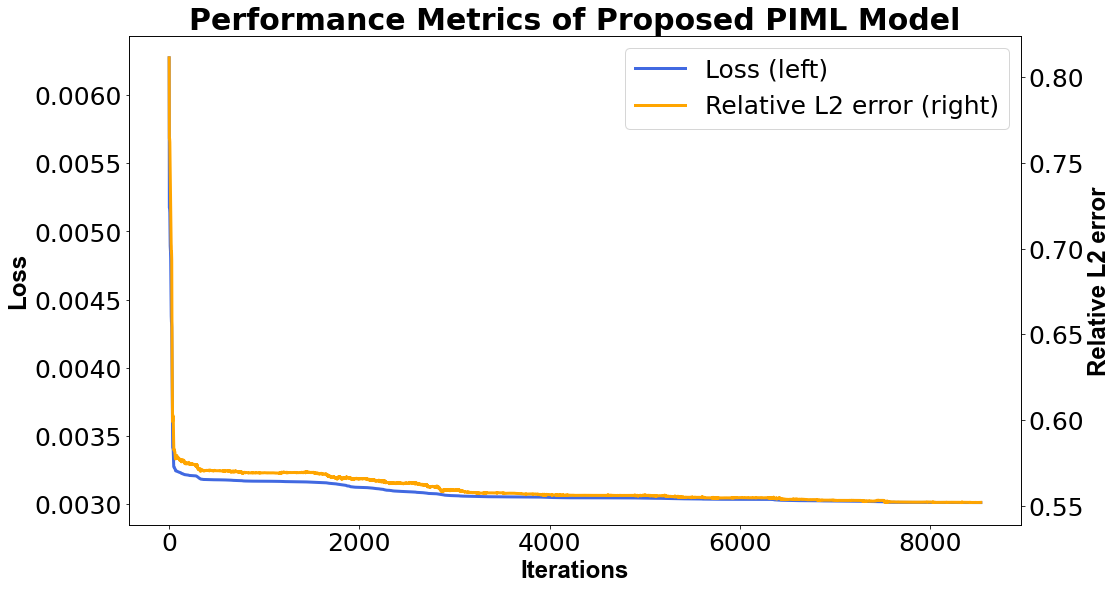

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.021027852239179308
MSE =  0.002777279740261841
RMSE =  0.05269990265894085
L2 relative error = 0.5013000105242853
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

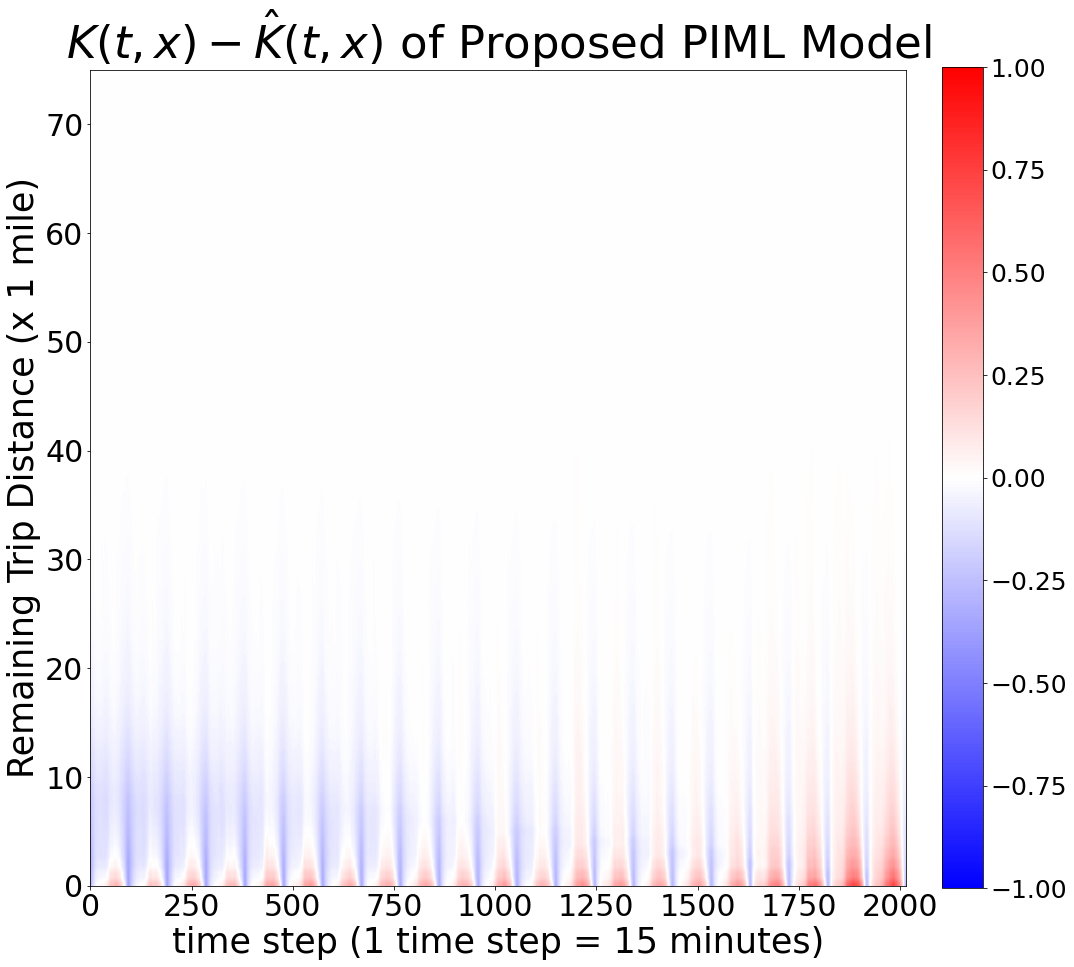

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

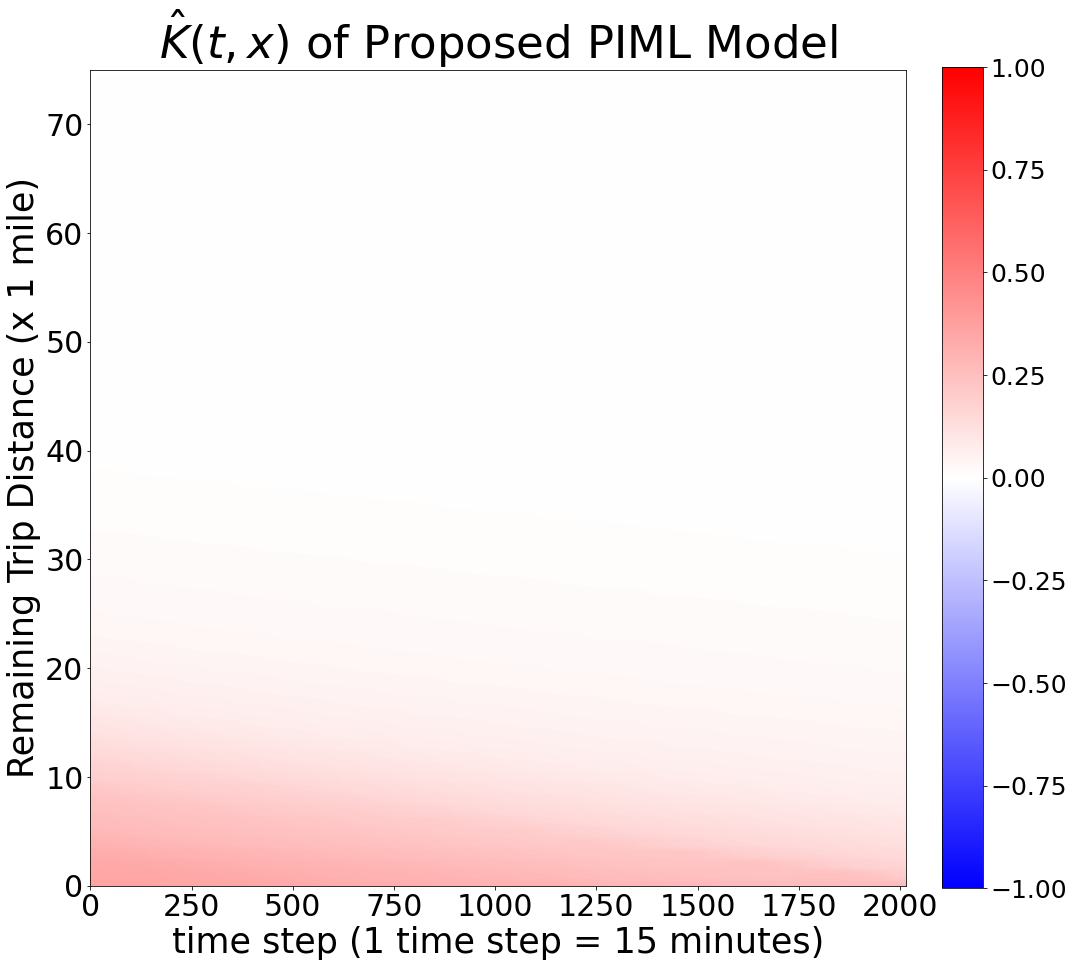

In [23]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

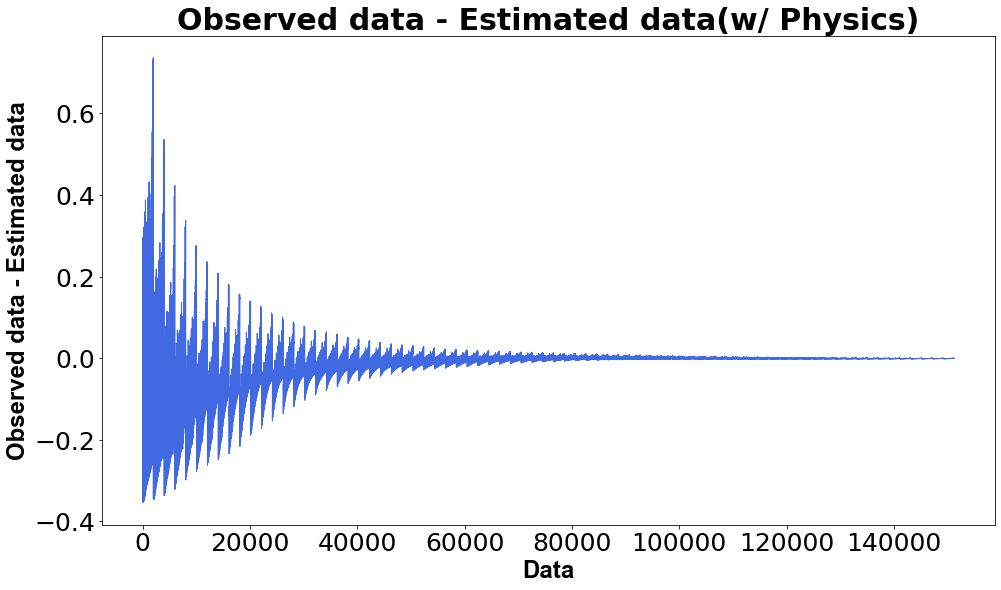

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

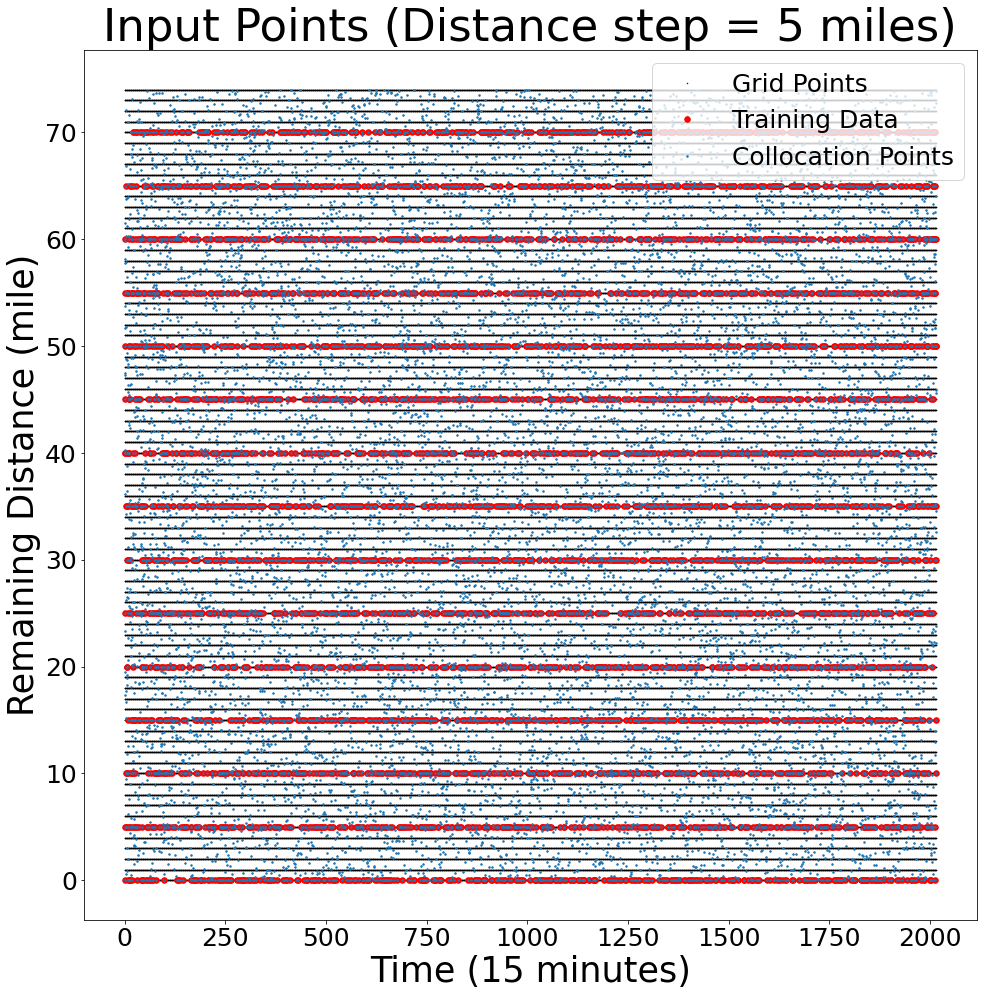

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()